In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
from pymc.Matplot import plot as pmplot

sns.set()

In [23]:
dick = pd.read_pickle('country_data.pkl')

def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})

def process_country(country_name):
    
    country = dick[country_name]
    country_population = country_populations.loc[country_name,'population']
    country['conf_per_M'] = country['confirmed'] / (country_population / 1e6)
    country['dead_per_M'] = country['deceased'] / (country_population / 1e6)
    
    return country



(array([2.0900e+02, 3.6980e+03, 1.9677e+04, 3.5049e+04, 2.7268e+04,
        1.0985e+04, 2.6530e+03, 4.1000e+02, 4.8000e+01, 3.0000e+00]),
 array([1.19545427, 1.36224505, 1.52903583, 1.69582662, 1.8626174 ,
        2.02940819, 2.19619897, 2.36298975, 2.52978054, 2.69657132,
        2.86336211]),
 <a list of 10 Patch objects>)

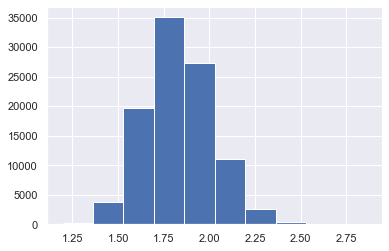

In [24]:
r_prior = pm.rlognormal(0.6, 1 / 0.1 ** 2,100000)
f_prior = pm.rbeta(5,200,100000)

plt.hist(r_prior)

In [25]:
### ASSUMPTIONS ###
### 1) nr of dead inc is a function of nr of confirmed
### 2) D = f * C
### 3) D = C * r * f 

def inference(df,C,D,country_name):
   
    alpha=10

    #f_alpha = 5
    #f_beta = 100
    
    f_alpha = pm.Uniform('f_alpha',1,100)
    f_beta = pm.Uniform ('f_beta',50,500)
    
    r_mu = pm.Uniform('r_mu',0.05,0.6)
    r_sigma = pm.Uniform('r_sigma',0,0.2)
    
    r = pm.Lognormal('r',r_mu, 1 / r_sigma ** 2)
    
    #r = pm.Lognormal('r',0.27,1/0.05**2)
    
    f = pm.Beta('f',f_alpha,f_beta)
    #m = pm.Uniform ('m',-2,2)

    @pm.deterministic()
    def prediction(C=C,r=r,f=f):
        return C * r * f 

    obs = pm.Poisson('obs',prediction, observed=True,value=D)

    model = pm.Model([r_mu, r_sigma,f_alpha,f_beta,f,r,prediction,obs])
    try:
        map_ = pm.MAP(model)
        map_.fit()
        
    except:
        print ('cant fit {}'.format(country_name))

    mcmc = pm.MCMC(model)

    mcmc.sample(500000,100000,5)

    r_mu_post = mcmc.trace('r_mu')[:]
    r_sigma_post = mcmc.trace('r_sigma')[:]
    r_post = mcmc.trace('r')[:]
    f_post = mcmc.trace('f')[:]
    f_alpha_post = mcmc.trace('f_alpha')[:]
    f_beta_post = mcmc.trace('f_beta')[:]
    
    
    pmplot(r_mu_post,'r_mu_post')
    pmplot(r_sigma_post,'r_sigma_post')
    pmplot(f_alpha_post,'f_alpha_post')
    pmplot(f_beta_post,'f_beta_post')
    pmplot(r_post,'r_post')
    pmplot(f_post,'f_post')
    
    prediction_post = mcmc.trace('prediction')[:,0]

    result = pd.DataFrame({'r_post':r_post,
                          'f_post':f_post,
                          'prediction_post':prediction_post})

    print ()
    print ('++++++++++++++ {} ++++++++++++++++'.format(country_name))
    print (result.describe())
    print()
    
    plt.figure(figsize=(18,12))
    plt.hist(r_prior,color='r',label='r prior',alpha=0.5,histtype='stepfilled',density=True)
    plt.hist(result.r_post,color='g',label='r posterior',alpha=0.7,histtype='stepfilled',density=True)
    plt.legend(loc='upper left')

    plt.figure(figsize=(18,12))
    plt.hist(f_prior,color='r',label='f prior',alpha=0.5,histtype='stepfilled',density=True)
    plt.hist(result.f_post,color='g',label='f posterior',alpha=0.7,histtype='stepfilled',density=True)
    
    plt.legend(loc='upper left')
    
    return result



In [26]:
def create_posterior_samples(result):
    N = 10000
    f_samples = np.random.choice(result.f_post,replace=True,size=N)
    r_samples = np.random.choice(result.r_post,replace=True,size=N)

    samples = np.array([pm.rpoisson(C[i] * r_samples * f_samples,N) for i in range(len(C))])

    samples.shape

    sample_df = pd.DataFrame(samples,index=range(len(samples)))
    sample_df.index.name='day'
    sample_df.columns.name='sample_nr'
    return sample_df

In [27]:

def plot(result,df,sample_df,country_name):
    
    samples_89 = np.percentile(sample_df.iloc[-1,:],[5.5,94.5])
    samples_daily_mean = sample_df.mean(axis=1)

    
    plt.figure(figsize=(18,12))
    title_postfix = r' Sample posterior mean growth factor $\mu$: {:.2f} posterior mean mortality rate $\mu$: {:.4f}'.format(
    result.r_post.mean(),result.f_post.mean())
    
    title_postfix_2 = ' Last Day Sample 89% CI: {:.2f} , {:.2f} : Last Week Actual: {}'.format(
        samples_89[0],samples_89[1],df.iloc[-1,2])


    sns.violinplot(data=sample_df.T,inner='quartile',scale='count',palette=['lime'])
    plt.plot(range(len(df)),samples_daily_mean,color='crimson',ls='dashed',label='death samples weekly mean ')


    plt.title('Bayesian Posterior Expected number of deaths per week {}, after the day CONFIRMED hit {} \n'.format(
        country_name.upper(),limit) + title_postfix + '\n' + title_postfix_2)

    plt.ylabel('Expected number of deaths per week')
    plt.xlabel('Week after number of confirmed hit {}'.format(limit))
    plt.scatter(range(len(df)),df['dead_inc'],color='crimson',label='actual data')
    plt.legend(loc='upper left')
    
    plt.savefig('{}_violinplot_weekly.jpg'.format(country_name),format='jpg')
    

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



+++++++++++++ Sweden +++++++++++++
               confirmed     inc  dead_inc     deceased
2020-03-19   1206.600000   478.0       9.0     7.400000
2020-03-26   2147.714286  1401.0      66.0    36.714286
2020-04-02   4170.571429  2728.0     231.0   170.428571
2020-04-09   7409.000000  3573.0     485.0   525.714286
2020-04-16  11025.571429  3399.0     540.0  1020.571429
2020-04-23  14897.285714  4215.0     688.0  1679.142857
2020-04-30  19189.285714  4337.0     565.0  2316.428571
2020-05-07  22913.857143  3531.0     454.0  2800.714286
2020-05-14  26848.714286  3959.0     489.0  3311.142857
2020-05-21  30556.857143  3590.0     342.0  3734.571429
2020-05-28  34079.142857  3555.0     395.0  4079.285714
2020-06-04  38602.857143  6156.0     296.0  4445.000000
2020-06-11  45387.857143  6405.0     252.0  4710.571429
2020-06-18  52648.571429  7755.0     239.0  4932.285714
 [-----------------100%-----------------] 500000 of 500000 complete in 623.6 secPlotting r_mu_post
Plotting r_sigma_post
Plo

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



+++++++++++++ US +++++++++++++
               confirmed       inc  dead_inc       deceased
2020-03-12  1.335000e+03     850.0      15.0      37.500000
2020-03-19  5.937571e+03   12592.0     226.0     125.285714
2020-03-26  4.673286e+04   69927.0    1467.0     898.571429
2020-04-02  1.679543e+05  160513.0    6613.0    4829.571429
2020-04-09  3.690196e+05  219849.0   12066.0   14562.857143
2020-04-16  5.829027e+05  204830.0   14616.0   28523.142857
2020-04-23  7.843783e+05  202345.0   14938.0   43512.142857
2020-04-30  9.913369e+05  201050.0   13322.0   57228.571429
2020-05-07  1.184537e+06  188742.0   12695.0   70040.857143
2020-05-14  1.354952e+06  162317.0   10243.0   81554.428571
2020-05-21  1.515699e+06  160760.0    8791.0   91224.142857
2020-05-28  1.669609e+06  145773.0    6917.0   98886.000000
2020-06-04  1.817499e+06  148284.0    6542.0  105662.857143
2020-06-11  1.962949e+06  145047.0    5344.0  111426.857143
2020-06-18  2.117667e+06  167462.0    4611.0  116439.714286
 [------

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



+++++++++++++ India +++++++++++++
                confirmed      inc  dead_inc      deceased
2020-04-02    1642.600000   1556.0      48.0     44.800000
2020-04-09    4566.714286   4182.0     154.0    135.285714
2020-04-16   10420.142857   6705.0     222.0    352.714286
2020-04-23   18679.285714   9647.0     273.0    600.714286
2020-04-30   29629.000000  11786.0     433.0    952.285714
2020-05-07   46376.571429  21488.0     735.0   1552.857143
2020-05-14   70682.285714  25646.0     760.0   2315.285714
2020-05-21  101312.428571  36229.0     935.0   3160.714286
2020-05-28  144852.571429  47160.0    1127.0   4197.000000
2020-06-04  199289.285714  61327.0    1652.0   5637.285714
2020-06-11  266643.714286  70822.0    2135.0   7517.857143
2020-06-18  343853.285714  82997.0    4075.0  10601.714286
 [-----------------100%-----------------] 500000 of 500000 complete in 660.0 secPlotting r_mu_post
Plotting r_sigma_post
Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ India ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.321980      0.025977        51.451620
std        0.261712      0.005023         0.460294
min        0.627583      0.013722        49.553317
25%        1.121392      0.021970        51.140507
50%        1.268154      0.026075        51.450576
75%        1.504851      0.029485        51.760369
max        2.418429      0.052606        53.495342



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Italy +++++++++++++
                confirmed      inc  dead_inc      deceased
2020-03-05    2384.500000   2970.0     127.0     74.833333
2020-03-12    9255.714286  11255.0     868.0    533.285714
2020-03-19   28542.571429  25922.0    2389.0   2222.857143
2020-03-26   63973.571429  39554.0    4810.0   6135.428571
2020-04-02  101429.428571  34653.0    5700.0  11575.000000
2020-04-09  132084.000000  28384.0    4364.0  16504.000000
2020-04-16  158901.571429  25315.0    3891.0  20509.000000
2020-04-23  181402.285714  21032.0    3379.0  24146.857143
2020-04-30  199427.571429  15490.0    2418.0  26997.428571
2020-05-07  211819.857143  10395.0    1991.0  29123.714286
2020-05-14  220107.571429   7238.0    1410.0  30754.285714
2020-05-21  226005.000000   4910.0    1118.0  32039.000000
2020-05-28  230203.857143   3726.0     656.0  32883.142857
2020-06-04  233210.000000   2281.0     547.0  33468.428571
2020-06-11  235296.285714   2129.0     478.0  33972.428571
2020-06-18  237246.00

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Italy ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.347092      0.111790       431.786533
std        0.249093      0.021404         2.320611
min        0.758757      0.067850       420.598926
25%        1.144584      0.094176       430.230245
50%        1.326229      0.109612       431.779873
75%        1.544199      0.126978       433.351143
max        2.141127      0.193192       442.403292



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Korea, South +++++++++++++
               confirmed     inc  dead_inc    deceased
2020-02-27   1513.500000   789.0       3.0   12.500000
2020-03-05   4350.428571  4322.0      22.0   24.571429
2020-03-12   7366.142857  1781.0      31.0   52.714286
2020-03-19   8251.571429   696.0      25.0   77.714286
2020-03-26   8969.714286   676.0      40.0  113.571429
2020-04-02   9671.857143   735.0      38.0  155.571429
2020-04-09  10268.142857   447.0      35.0  188.000000
2020-04-16  10535.285714   190.0      25.0  218.000000
2020-04-23  10672.571429    95.0      11.0  235.285714
2020-04-30  10748.000000    66.0       8.0  244.285714
2020-05-07  10802.285714    48.0       8.0  253.285714
2020-05-14  10932.857143   196.0       4.0  257.857143
2020-05-21  11086.285714   124.0       4.0  263.000000
2020-05-28  11256.714286   260.0       5.0  267.857143
2020-06-04  11548.571429   266.0       4.0  271.571429
2020-06-11  11859.000000   335.0       4.0  274.571429
2020-06-18  12167.57142

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Korea, South ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.361267      0.018248        18.872853
std        0.268034      0.003731         1.145521
min        0.620361      0.007821        14.138274
25%        1.158526      0.015473        18.088168
50%        1.327891      0.017965        18.845444
75%        1.539148      0.020680        19.635847
max        3.114680      0.041412        23.743664



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Netherlands +++++++++++++
               confirmed     inc  dead_inc     deceased
2020-03-19   1758.000000  1505.0      65.0    44.400000
2020-03-26   5015.714286  5001.0     358.0   243.857143
2020-04-02  11766.285714  7320.0     906.0   911.428571
2020-04-09  18817.285714  7115.0    1062.0  1936.714286
2020-04-16  26507.857143  7480.0     924.0  2882.857143
2020-04-23  33440.142857  6538.0     865.0  3819.142857
2020-04-30  38245.000000  3591.0     619.0  4553.285714
2020-05-07  40991.000000  2461.0     495.0  5113.428571
2020-05-14  42994.142857  1707.0     303.0  5495.857143
2020-05-21  44354.571429  1220.0     185.0  5722.571429
2020-05-28  45619.857143  1252.0     128.0  5859.142857
2020-06-04  46731.571429   996.0      87.0  5981.000000
2020-06-11  47926.428571  1310.0      54.0  6042.142857
2020-06-18  49127.714286  1069.0      34.0  6084.142857
 [-----------------100%-----------------] 500000 of 500000 complete in 690.8 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Netherlands ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.360932      0.095727       188.605240
std        0.270199      0.019131         2.421918
min        0.639111      0.043653       177.315038
25%        1.156449      0.081264       186.965009
50%        1.331397      0.094138       188.597914
75%        1.541767      0.108347       190.213009
max        2.850478      0.195416       199.024387



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Canada +++++++++++++
                confirmed      inc  dead_inc     deceased
2020-03-26    2486.166667   3099.0      26.0    26.500000
2020-04-02    7615.285714   7242.0     101.0    86.857143
2020-04-09   16485.857143   9370.0     364.0   325.714286
2020-04-16   25915.285714  10155.0     756.0   839.142857
2020-04-23   37832.142857  12490.0     982.0  1754.000000
2020-04-30   49630.142857  11158.0    1069.0  2849.857143
2020-05-07   61548.571429  11744.0    1231.0  4016.571429
2020-05-14   71245.000000   8580.0    1051.0  5134.714286
2020-05-21   79388.285714   7961.0     675.0  5969.571429
2020-05-28   87054.000000   7234.0     715.0  6660.857143
2020-06-04   93175.285714   5293.0     735.0  7396.285714
2020-06-11   97642.714286   3890.0     354.0  7927.714286
2020-06-18  100751.428571   2718.0     290.0  8242.571429
 [-----------------100%-----------------] 500000 of 500000 complete in 771.4 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Canada ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.371437      0.062810       256.378298
std        0.270540      0.013140         2.798086
min        0.604087      0.033988       243.183836
25%        1.170334      0.053192       254.502169
50%        1.354866      0.061077       256.365014
75%        1.554475      0.070696       258.243102
max        2.467923      0.138449       269.431121



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Germany +++++++++++++
                confirmed      inc  dead_inc     deceased
2020-03-12    1531.800000   1279.0       3.0     2.000000
2020-03-19    8318.714286  13242.0      41.0    20.000000
2020-03-26   30033.857143  28618.0     223.0   142.571429
2020-04-02   67431.428571  40856.0     840.0   679.285714
2020-04-09  104269.714286  33387.0    1500.0  1869.285714
2020-04-16  129830.714286  19517.0    1445.0  3267.000000
2020-04-23  147008.000000  15431.0    1523.0  4878.000000
2020-04-30  158928.571429   9880.0    1048.0  6163.285714
2020-05-07  166494.142857   6421.0     769.0  7009.571429
2020-05-14  172587.714286   5048.0     492.0  7681.714286
2020-05-21  177025.285714   4543.0     319.0  8032.571429
2020-05-28  180792.000000   3175.0     267.0  8335.857143
2020-06-04  183655.285714   2276.0     165.0  8561.285714
2020-06-11  185993.142857   2219.0     137.0  8710.142857
2020-06-18  188052.285714   3126.0     103.0  8818.571429
 [-----------------100%------------

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Germany ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.349680      0.036241        60.058751
std        0.280744      0.007246         0.638534
min        0.681612      0.018024        57.163919
25%        1.138919      0.030940        59.623164
50%        1.299176      0.036140        60.058165
75%        1.517620      0.041237        60.484943
max        2.596186      0.069182        63.084049



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ United Kingdom +++++++++++++
                confirmed      inc  dead_inc      deceased
2020-03-19    1859.666667   1914.0     149.0     82.333333
2020-03-26    7309.714286   9096.0     720.0    453.571429
2020-04-02   23401.285714  22361.0    2873.0   2231.285714
2020-04-09   52168.000000  31699.0    5871.0   6805.571429
2020-04-16   89675.428571  38273.0    6351.0  13250.142857
2020-04-23  125166.714286  35101.0    5866.0  19396.000000
2020-04-30  158266.571429  33235.0    5002.0  24786.000000
2020-05-07  192634.000000  35496.0    3847.0  29065.285714
2020-05-14  223871.571429  26463.0    3004.0  32396.428571
2020-05-21  246310.285714  17806.0    2431.0  35078.285714
2020-05-28  263319.571429  18262.0    1795.0  37099.142857
2020-06-04  277779.857143  12571.0    2068.0  39092.714286
2020-06-11  288930.285714   9781.0    1377.0  40820.285714
2020-06-18  298305.571429   9075.0    1009.0  41940.285714
 [-----------------100%-----------------] 500000 of 500000 complete in 

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ United Kingdom ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.356338      0.107919       269.270430
std        0.261156      0.022485         1.310512
min        0.722259      0.065752       263.647597
25%        1.161091      0.091385       268.386622
50%        1.359526      0.103473       269.265182
75%        1.539488      0.121201       270.147957
max        2.145295      0.193832       275.030127



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ France +++++++++++++
                confirmed      inc  dead_inc      deceased
2020-03-12    1747.000000   1334.0      37.0     33.400000
2020-03-19    6743.000000   8677.0     196.0    136.000000
2020-03-26   20194.285714  18581.0    1454.0    955.000000
2020-04-02   46841.428571  30378.0    3700.0   3328.428571
2020-04-09   75863.285714  27437.0    6830.0   9224.428571
2020-04-16  120533.142857  58709.0    5694.0  15326.571429
2020-04-23  153860.714286  12228.0    3936.0  20284.714286
2020-04-30  164667.714286   8996.0    2521.0  23307.428571
2020-05-07  170594.285714   7619.0    1611.0  25257.571429
2020-05-14  177593.142857   4076.0    1438.0  26724.857143
2020-05-21  180512.571429   2957.0     790.0  27970.714286
2020-05-28  183296.142857   4413.0     447.0  28464.857143
2020-06-04  189197.285714   3205.0     403.0  28881.000000
2020-06-11  191348.285714   2924.0     281.0  29228.428571
2020-06-18  194264.000000   2779.0     257.0  29480.142857
 [-----------------1

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ France ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.305657      0.120783       203.189569
std        0.249542      0.022328         1.178343
min        0.687491      0.064683       198.497616
25%        1.122907      0.104771       202.393981
50%        1.263600      0.120566       203.188369
75%        1.454066      0.135654       203.985795
max        2.365884      0.220933       208.750497



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Belgium +++++++++++++
               confirmed     inc  dead_inc     deceased
2020-03-19   1395.500000   909.0      17.0    12.500000
2020-03-26   3951.000000  4440.0     199.0   112.428571
2020-04-02  11605.714286  9113.0     791.0   590.000000
2020-04-09  20898.000000  9635.0    1512.0  1757.571429
2020-04-16  30631.714286  9826.0    2334.0  3903.142857
2020-04-23  39634.571429  7988.0    1633.0  5839.571429
2020-04-30  46593.000000  5722.0    1104.0  7189.000000
2020-05-07  50204.571429  2901.0     821.0  8000.857143
2020-05-14  53312.142857  2868.0     488.0  8710.285714
2020-05-21  55497.285714  1947.0     283.0  9077.142857
2020-05-28  57235.857143  1614.0     202.0  9303.857143
2020-06-04  58458.857143   918.0     160.0  9487.285714
2020-06-11  59324.285714   944.0      88.0  9604.428571
2020-06-18  60087.571429   637.0      47.0  9661.857143
 [-----------------100%-----------------] 500000 of 500000 complete in 685.2 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Belgium ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.365365      0.123480       147.981499
std        0.260225      0.022936         1.504049
min        0.751494      0.061674       140.553225
25%        1.164029      0.104943       146.965469
50%        1.325969      0.122788       147.976301
75%        1.551045      0.139861       148.992466
max        2.650644      0.217694       154.530989



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Austria +++++++++++++
               confirmed     inc  dead_inc    deceased
2020-03-19   1502.250000  1153.0       5.0    4.000000
2020-03-26   4434.000000  4896.0      43.0   22.571429
2020-04-02   9479.142857  4220.0     109.0  107.428571
2020-04-09  12354.000000  2115.0     137.0  227.000000
2020-04-16  14055.000000  1232.0     115.0  365.857143
2020-04-23  14801.428571   526.0     112.0  474.142857
2020-04-30  15275.571429   450.0      62.0  555.714286
2020-05-07  15627.571429   300.0      25.0  600.857143
2020-05-14  15910.857143   306.0      17.0  620.000000
2020-05-21  16271.285714   346.0       7.0  630.428571
2020-05-28  16534.285714   224.0      35.0  644.428571
2020-06-04  16734.142857   177.0       2.0  668.714286
2020-06-11  16947.000000   229.0       4.0  672.428571
2020-06-18  17143.000000   189.0      14.0  680.428571
 [-----------------100%-----------------] 500000 of 500000 complete in 679.3 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Austria ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.357340      0.032197        48.472687
std        0.270062      0.006492         1.852035
min        0.622245      0.014799        40.411311
25%        1.150395      0.027177        47.211662
50%        1.322660      0.031750        48.440583
75%        1.540175      0.036558        49.708624
max        2.857915      0.068915        57.259458



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Norway +++++++++++++
              confirmed     inc  dead_inc    deceased
2020-03-19  1400.500000   750.0       7.0    4.166667
2020-03-26  2622.000000  1623.0       7.0   10.142857
2020-04-02  4450.000000  1778.0      36.0   33.142857
2020-04-09  5836.428571  1064.0      58.0   80.857143
2020-04-16  6587.142857   685.0      44.0  133.571429
2020-04-23  7162.428571   505.0      42.0  176.285714
2020-04-30  7599.428571   337.0      16.0  204.142857
2020-05-07  7904.000000   296.0       7.0  213.428571
2020-05-14  8133.428571   162.0      15.0  224.142857
2020-05-21  8259.857143   113.0       3.0  233.000000
2020-05-28  8369.857143   102.0       1.0  235.142857
2020-06-04  8454.428571    93.0       2.0  236.571429
2020-06-11  8562.714286   104.0       4.0  239.000000
2020-06-18  8655.142857   100.0       2.0  242.428571
 [-----------------100%-----------------] 500000 of 500000 complete in 670.6 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Norway ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.362320      0.024192        23.816640
std        0.265978      0.004923         1.520294
min        0.572504      0.010193        18.029634
25%        1.159141      0.020473        22.773161
50%        1.328460      0.023831        23.781675
75%        1.542713      0.027443        24.822325
max        3.069290      0.055895        31.644195



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Denmark +++++++++++++
               confirmed     inc  dead_inc    deceased
2020-03-19   1122.000000   292.0       3.0    4.666667
2020-03-26   1635.142857   798.0      35.0   23.714286
2020-04-02   2826.714286  1550.0      82.0   83.285714
2020-04-09   4906.285714  2257.0     114.0  189.142857
2020-04-16   6534.714286  1244.0      84.0  284.857143
2020-04-23   7752.285714  1197.0      73.0  364.142857
2020-04-30   8904.428571  1085.0      58.0  428.428571
2020-05-07   9877.000000   925.0      62.0  490.714286
2020-05-14  10690.857143   630.0      23.0  529.571429
2020-05-21  11181.857143   469.0      24.0  548.714286
2020-05-28  11582.714286   332.0       7.0  563.285714
2020-06-04  11901.428571   299.0      14.0  575.857143
2020-06-11  12165.857143   224.0      11.0  590.571429
2020-06-18  12419.428571   309.0       7.0  597.428571
 [-----------------100%-----------------] 500000 of 500000 complete in 707.6 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Denmark ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.370740      0.039105        15.039484
std        0.276405      0.008039         0.614556
min        0.597286      0.016895        12.562192
25%        1.158742      0.032985        14.622835
50%        1.338482      0.038465        15.028525
75%        1.558842      0.044458        15.448340
max        2.931408      0.088310        17.899347



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Finland +++++++++++++
              confirmed     inc  dead_inc    deceased
2020-04-02  1311.714286   560.0      14.0   13.285714
2020-04-09  2142.857143  1087.0      23.0   30.857143
2020-04-16  3068.428571   764.0      33.0   60.428571
2020-04-23  3892.571429   915.0      97.0  118.000000
2020-04-30  4683.142857   711.0      39.0  194.571429
2020-05-07  5352.285714   678.0      44.0  237.285714
2020-05-14  5966.571429   472.0      32.0  272.714286
2020-05-21  6368.000000   348.0      19.0  299.857143
2020-05-28  6620.857143   250.0       7.0  309.285714
2020-06-04  6865.000000   168.0       9.0  318.714286
2020-06-11  7002.285714   153.0       3.0  323.285714
2020-06-18  7102.857143    55.0       1.0  325.714286
 [-----------------100%-----------------] 500000 of 500000 complete in 678.6 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Finland ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.355514      0.040067        29.270125
std        0.268422      0.008206         1.629780
min        0.580142      0.016957        22.740951
25%        1.152662      0.033890        28.155882
50%        1.319363      0.039501        29.238247
75%        1.535588      0.045377        30.354621
max        3.028857      0.092349        36.992570



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


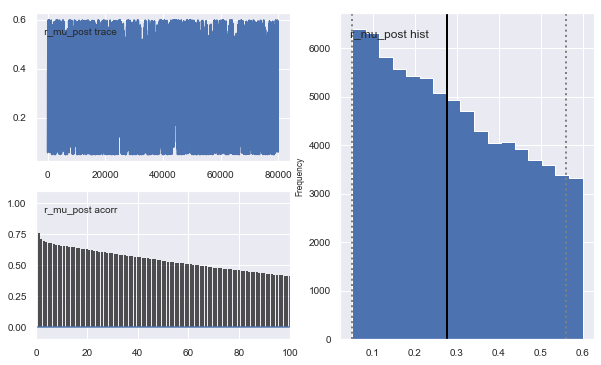

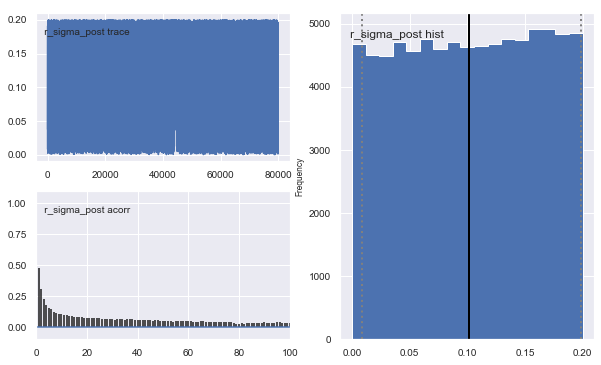

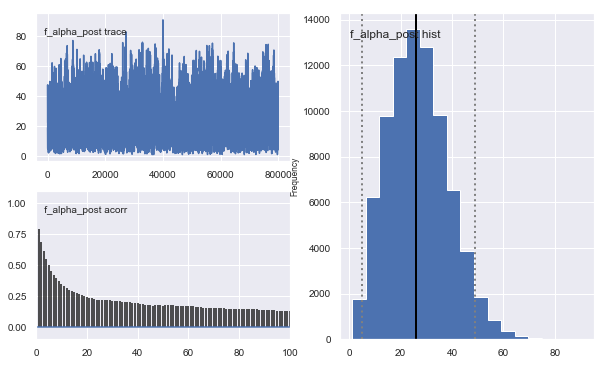

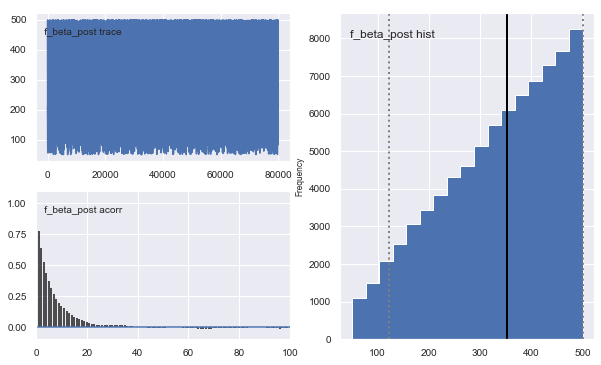

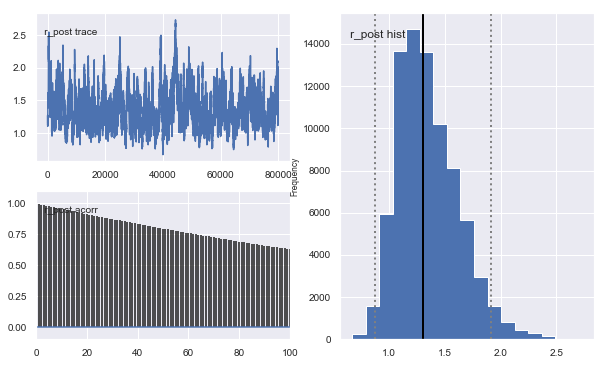

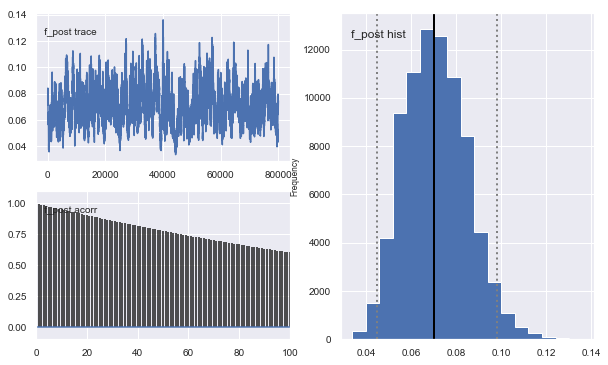

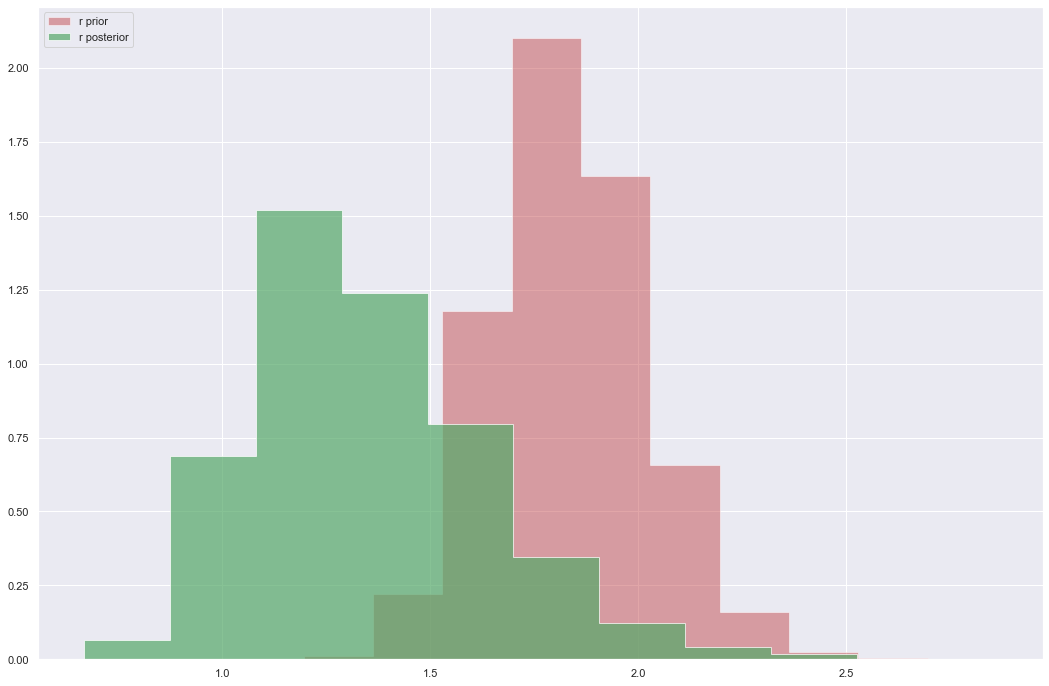

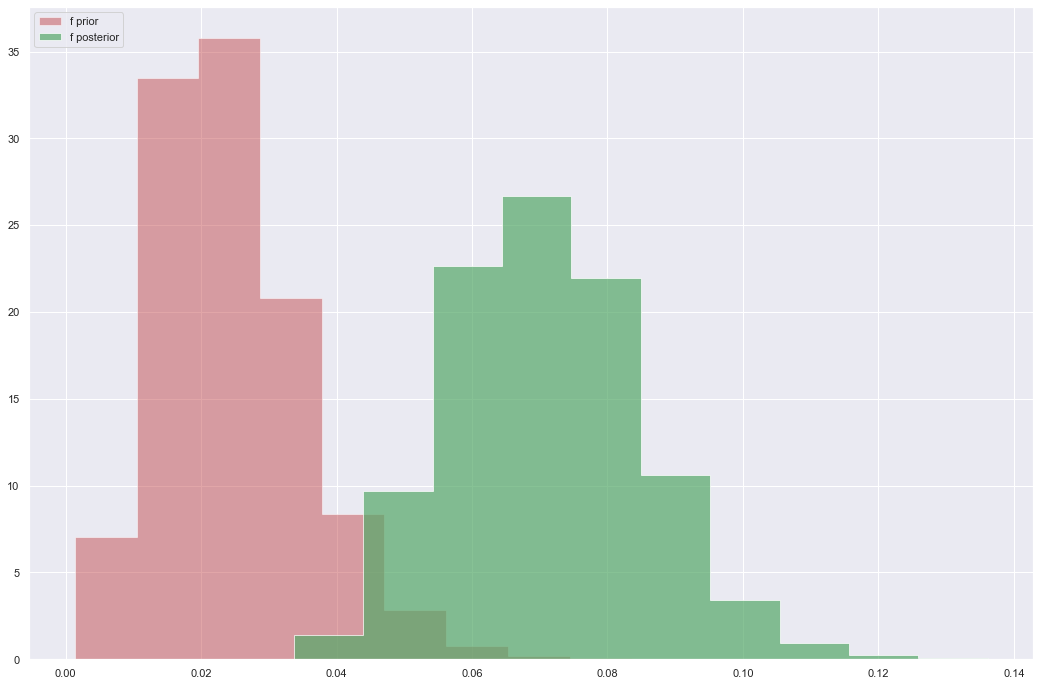

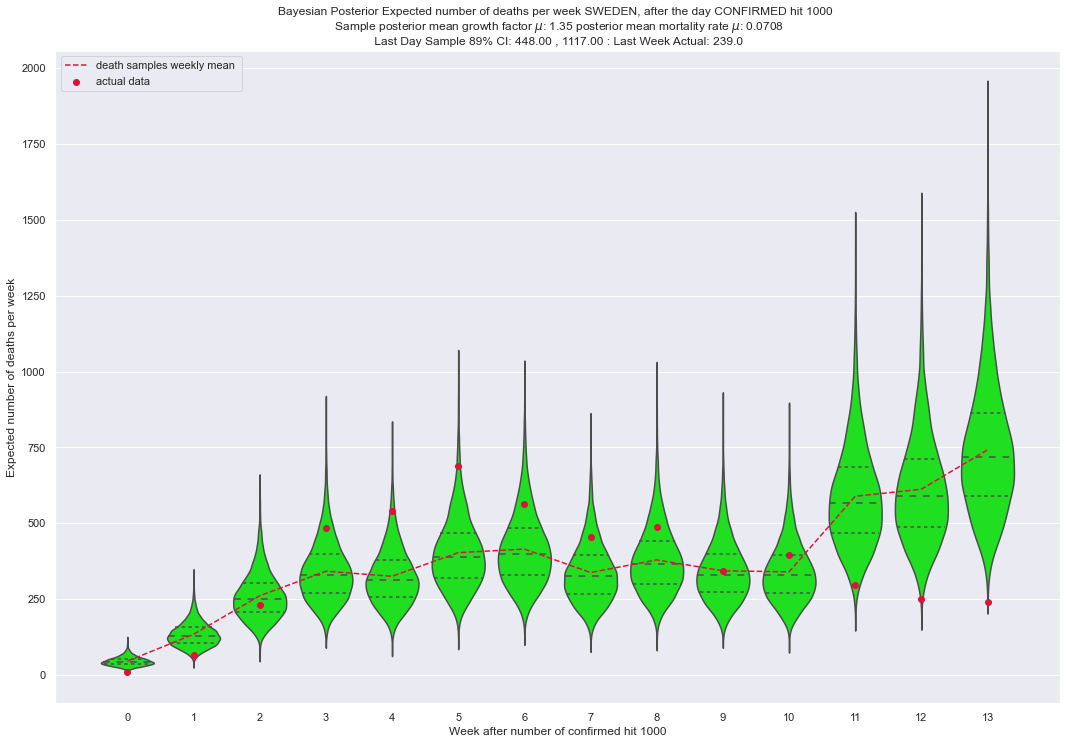

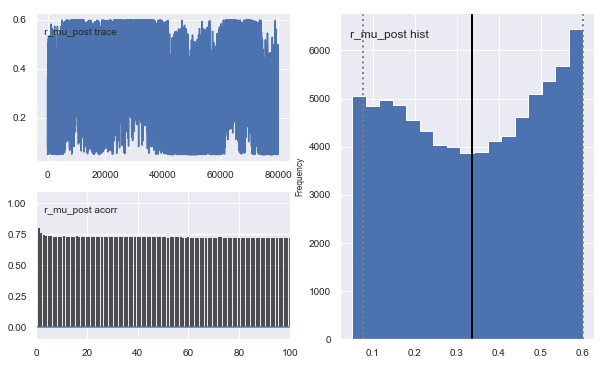

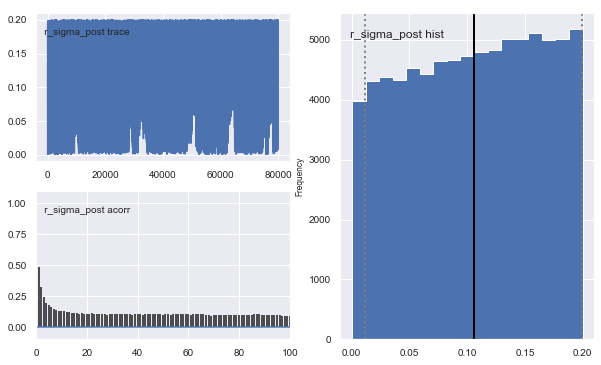

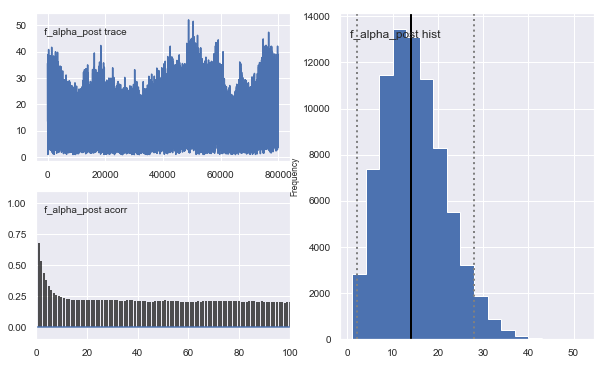

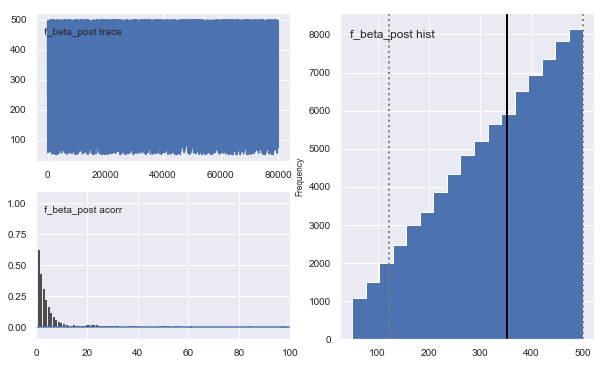

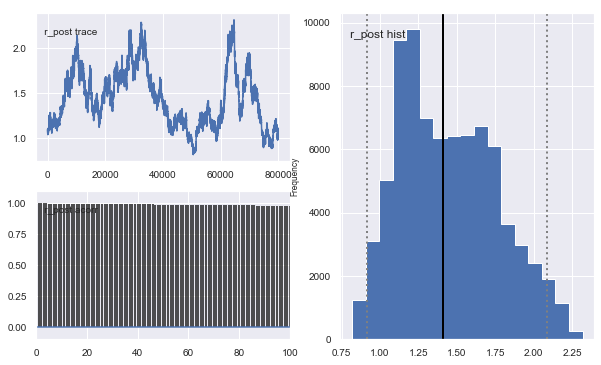

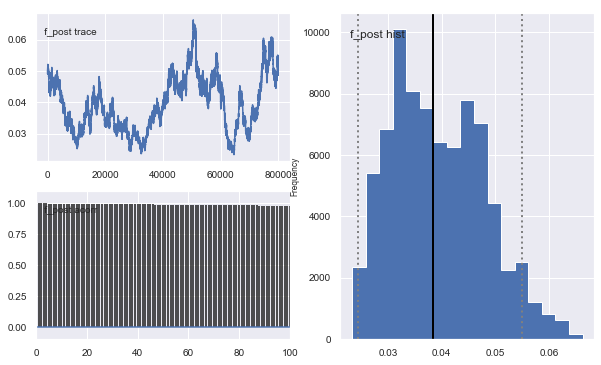

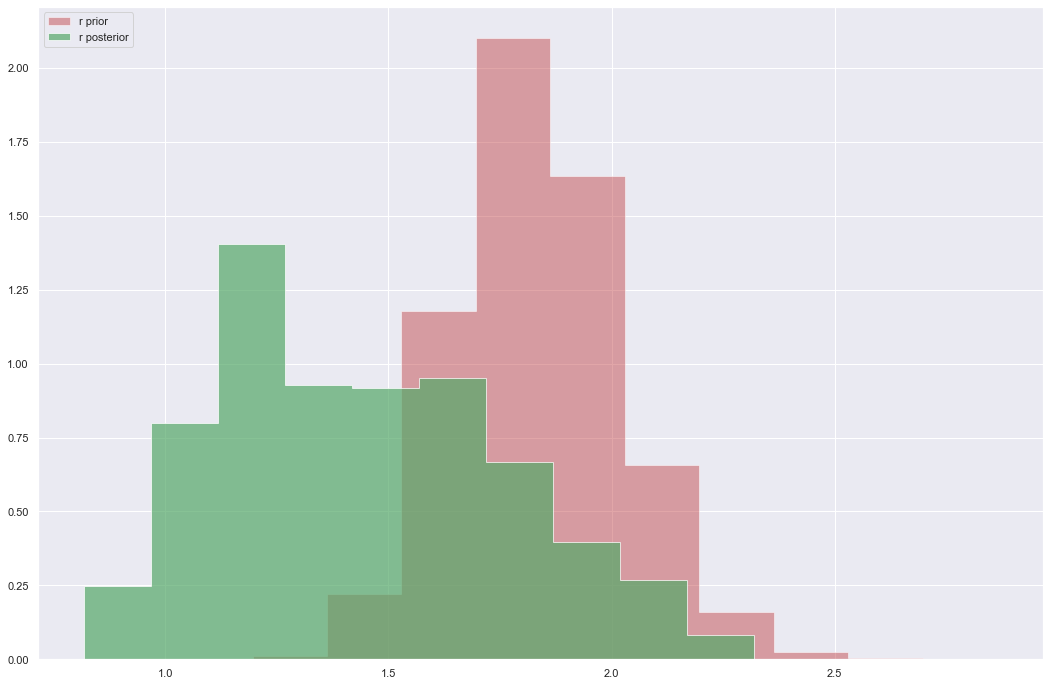

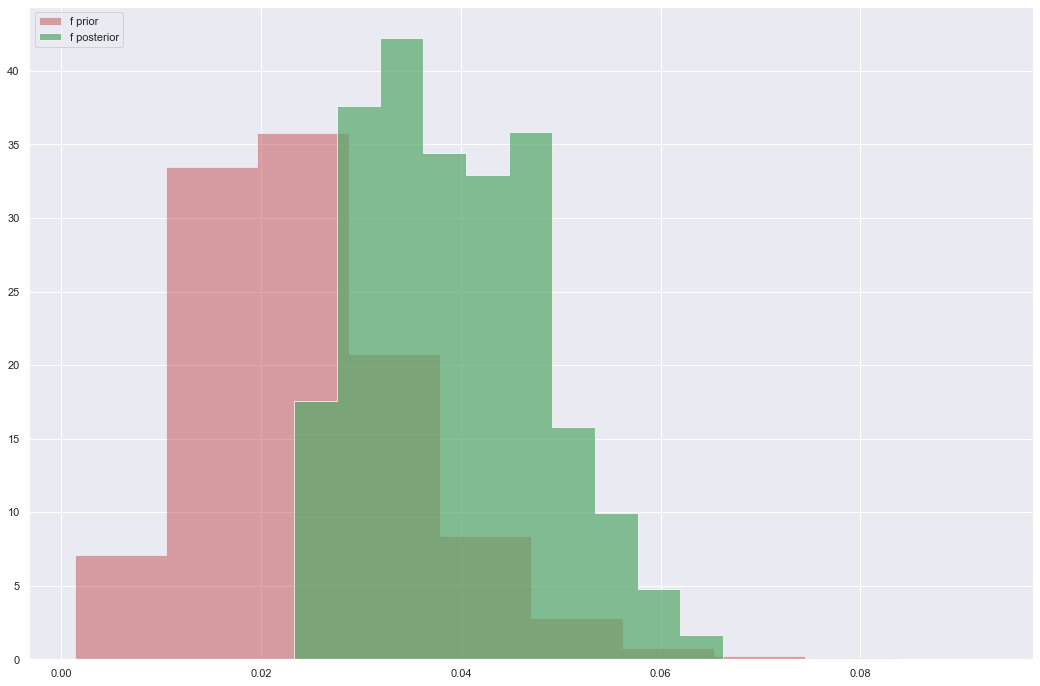

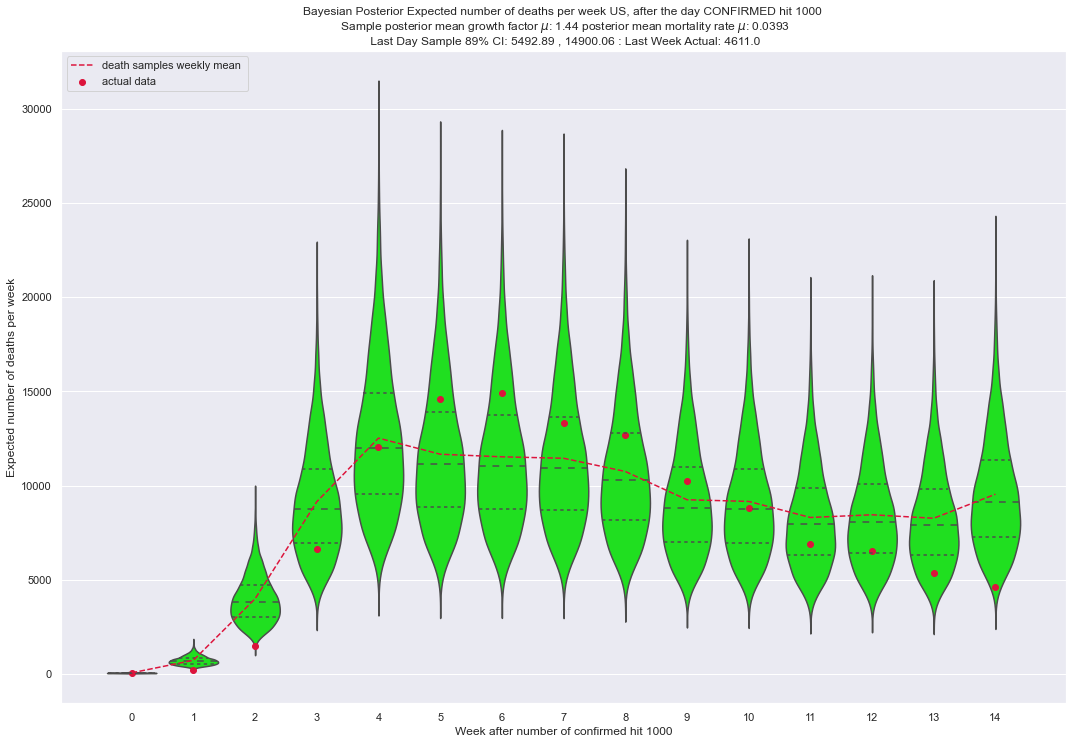

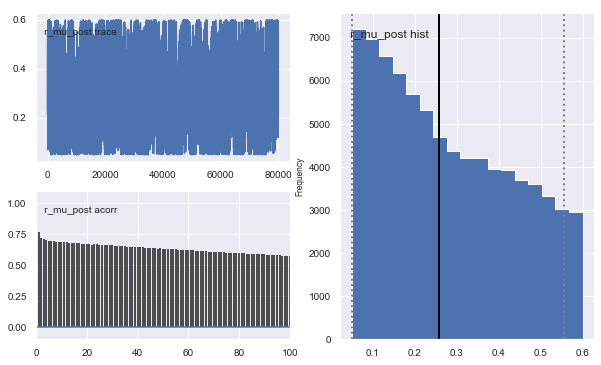

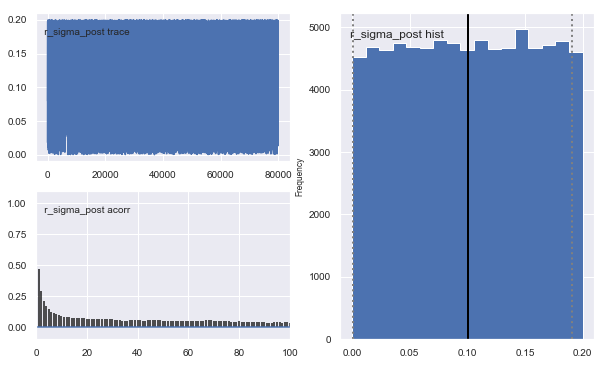

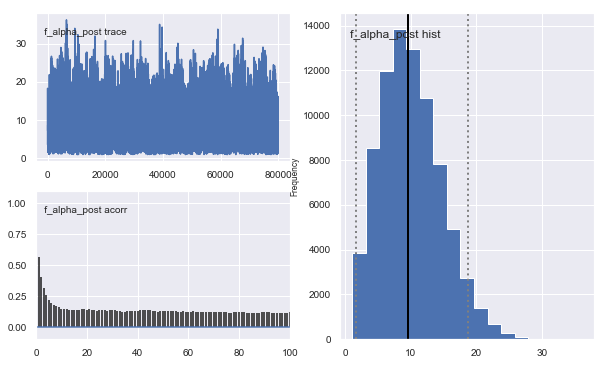

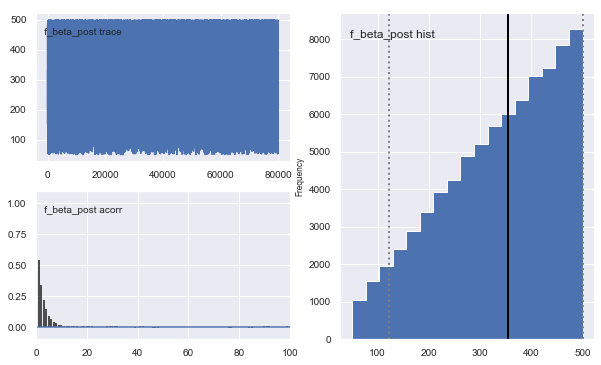

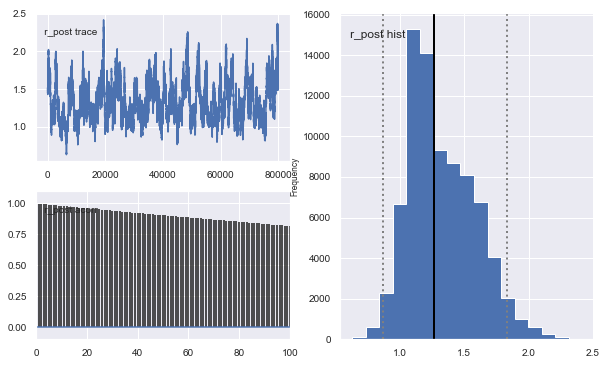

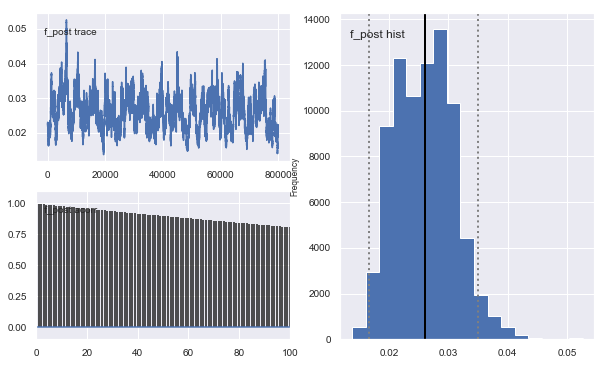

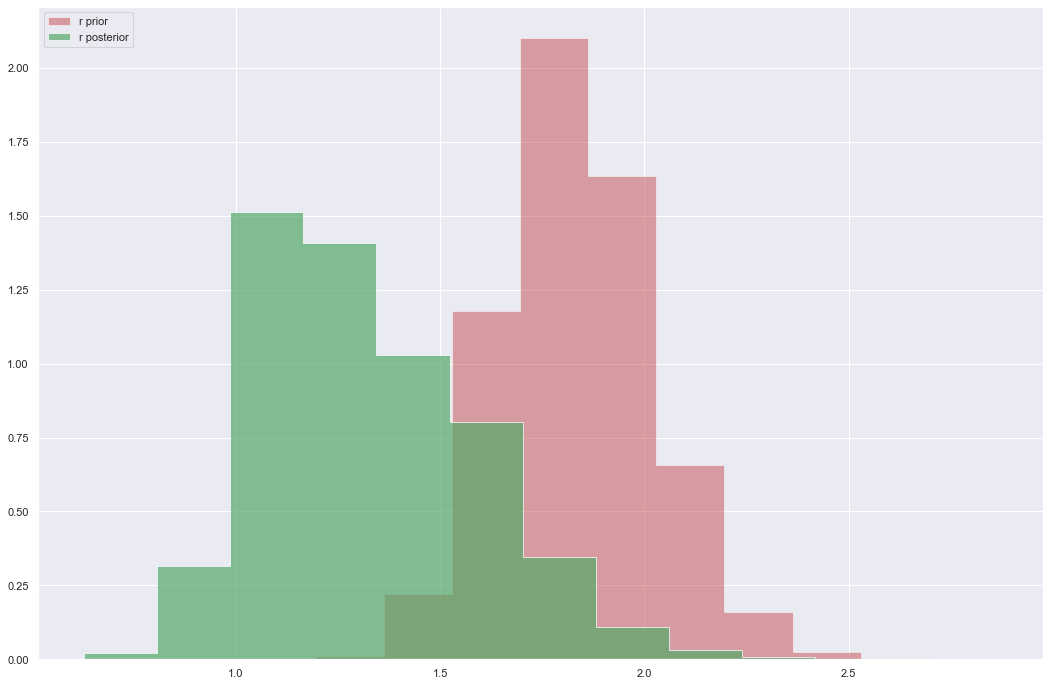

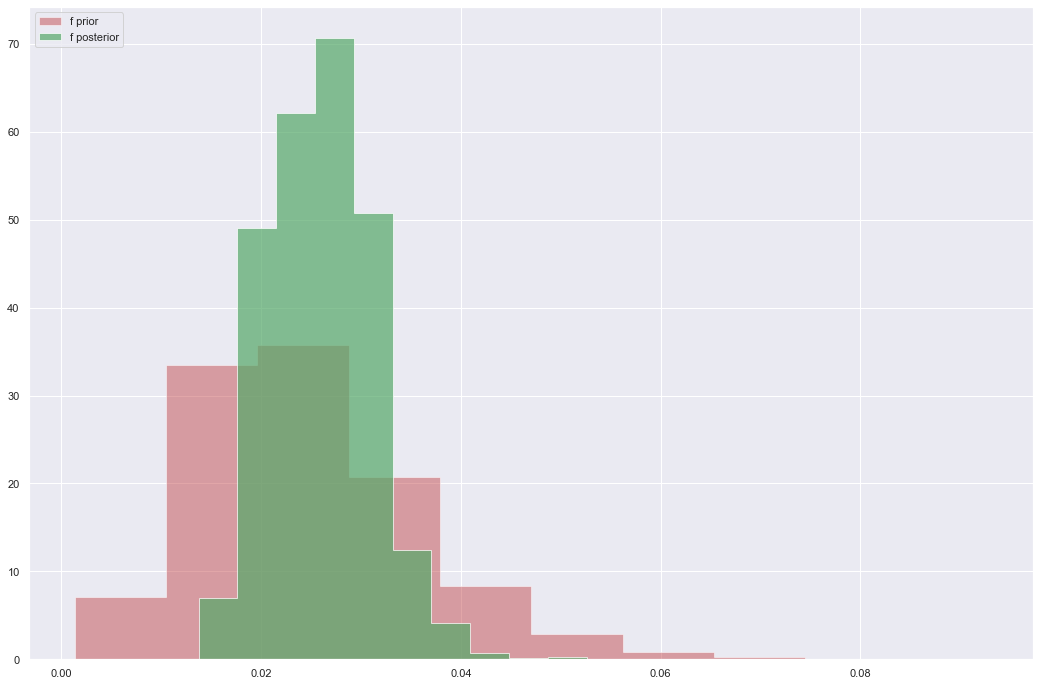

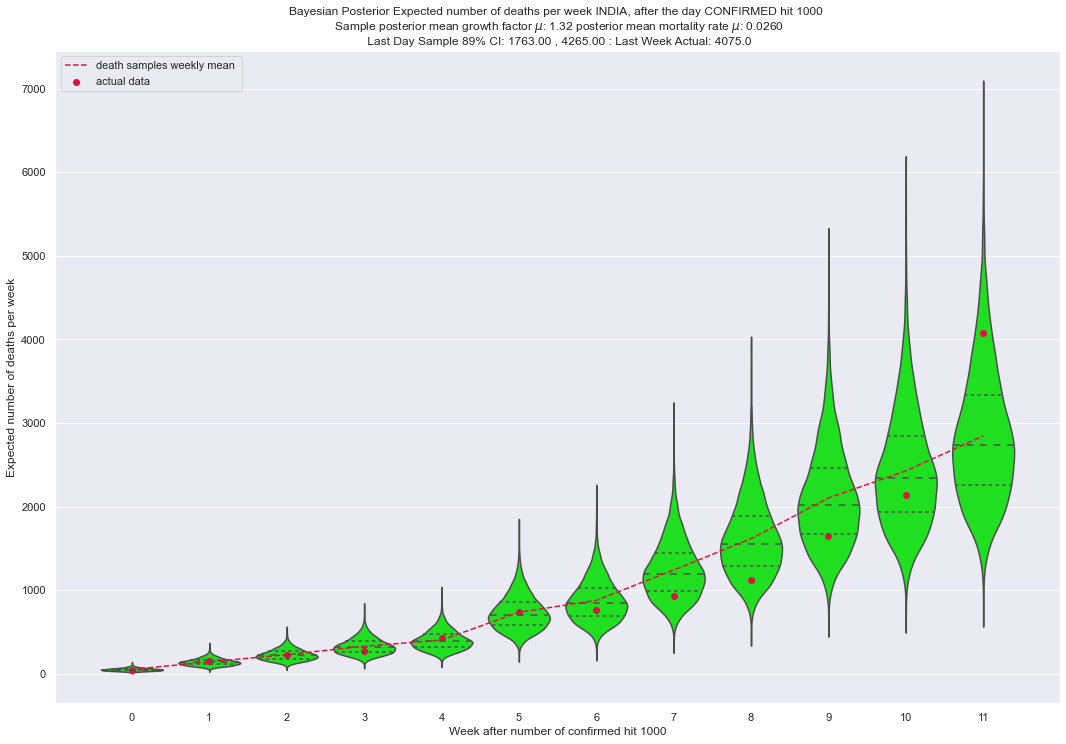

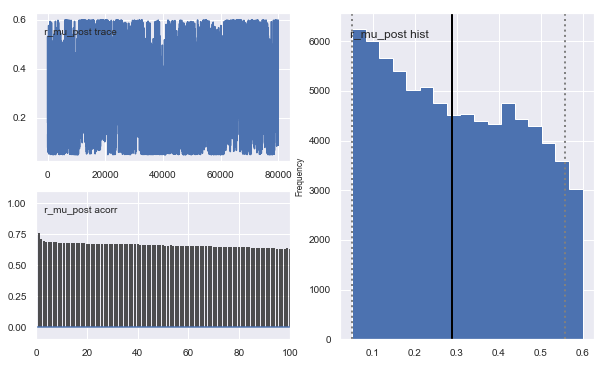

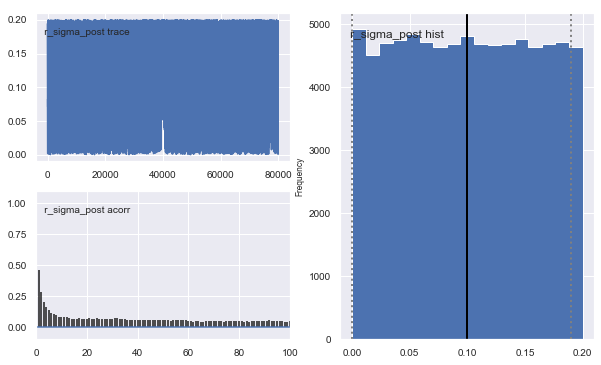

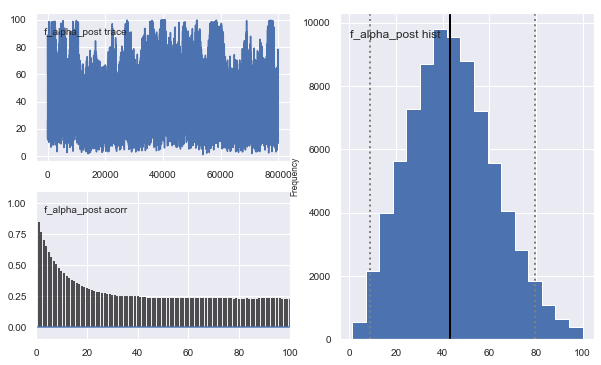

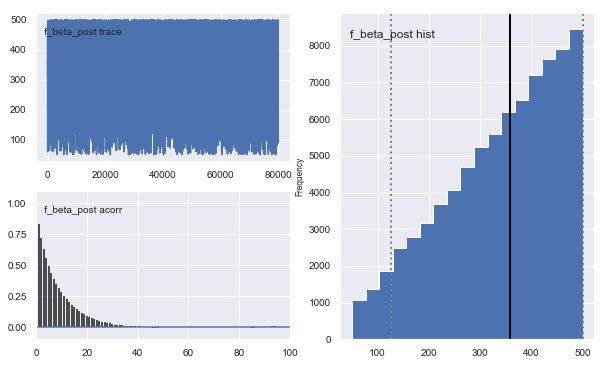

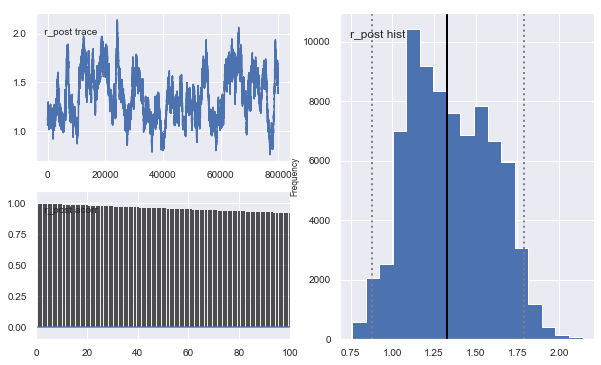

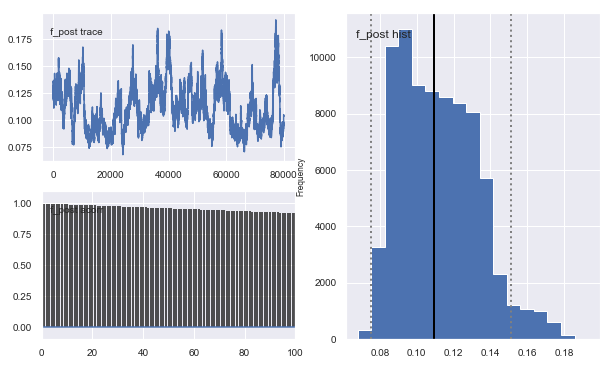

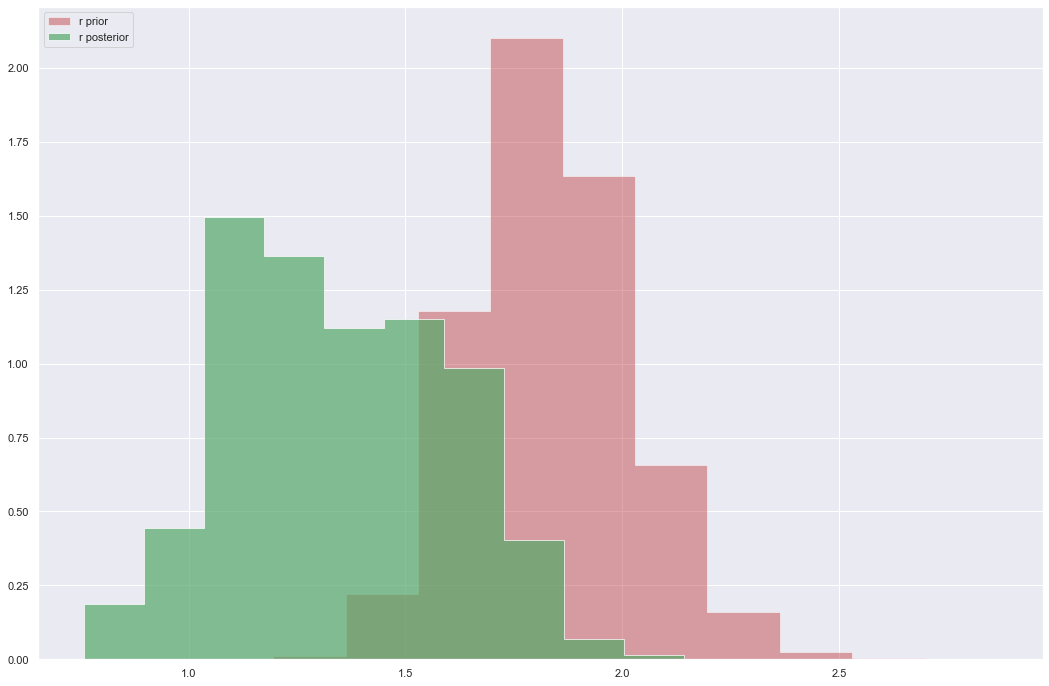

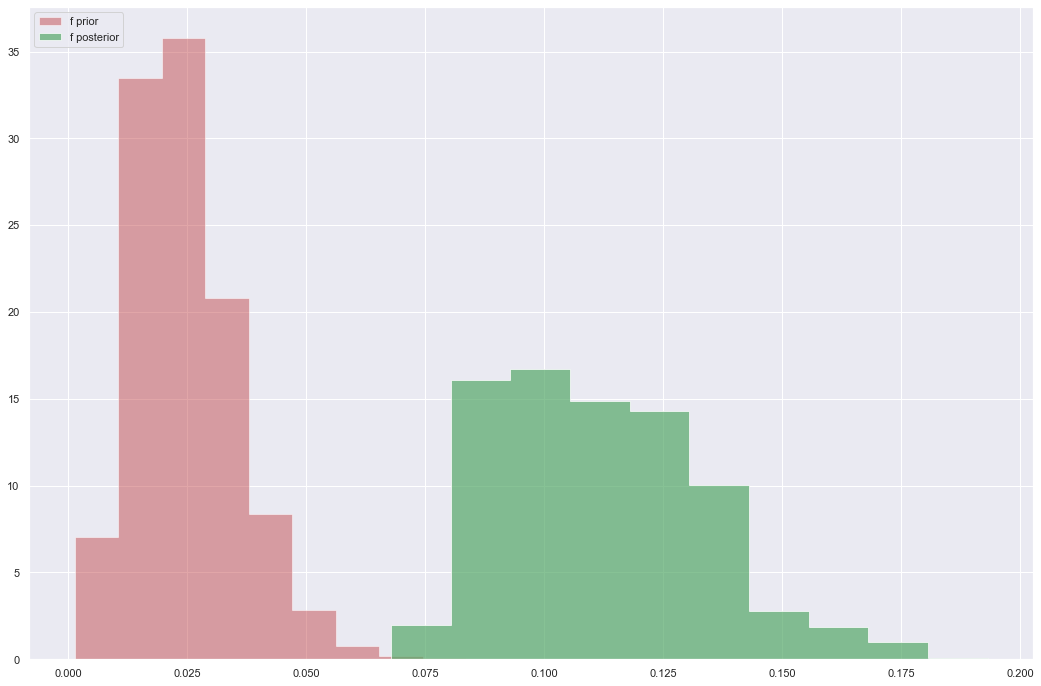

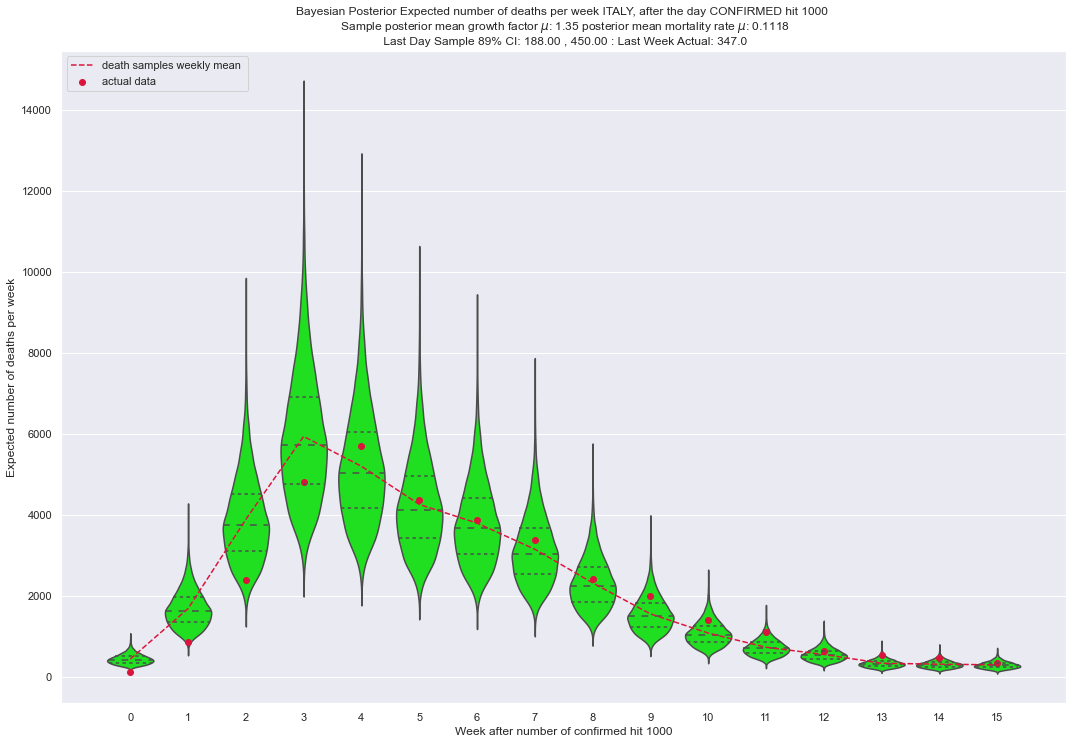

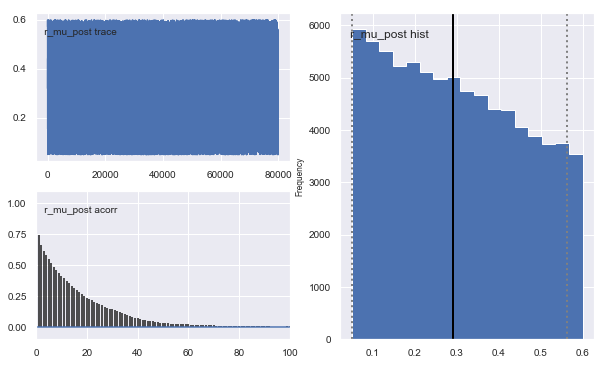

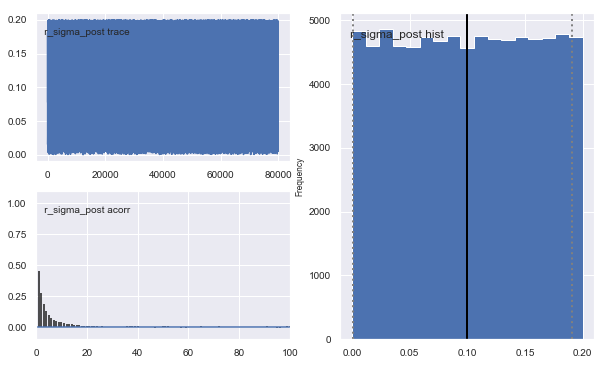

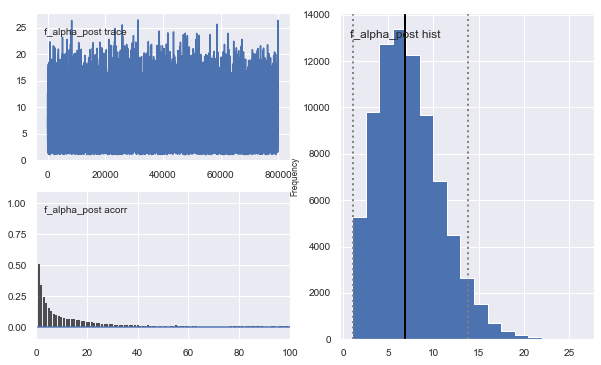

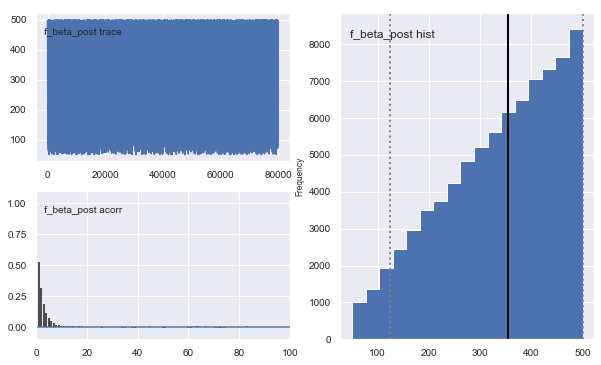

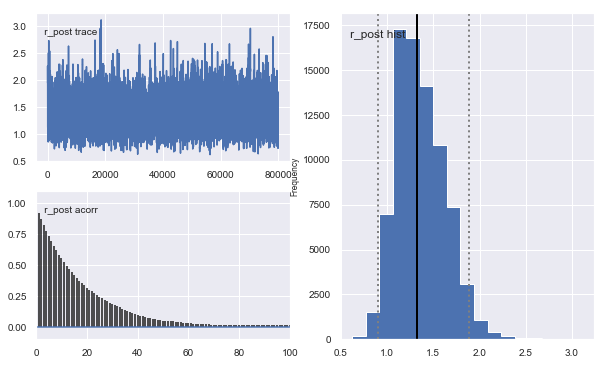

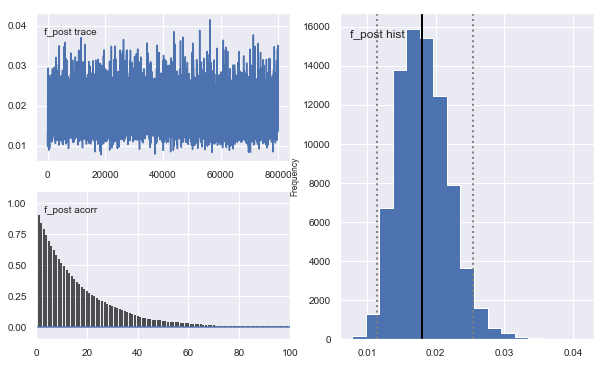

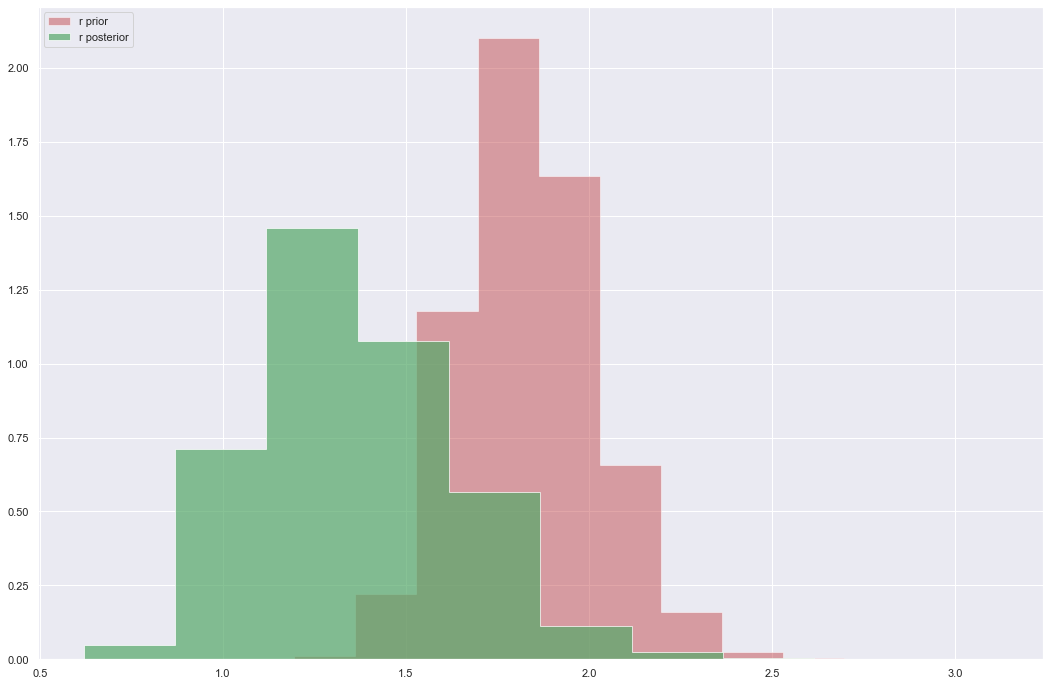

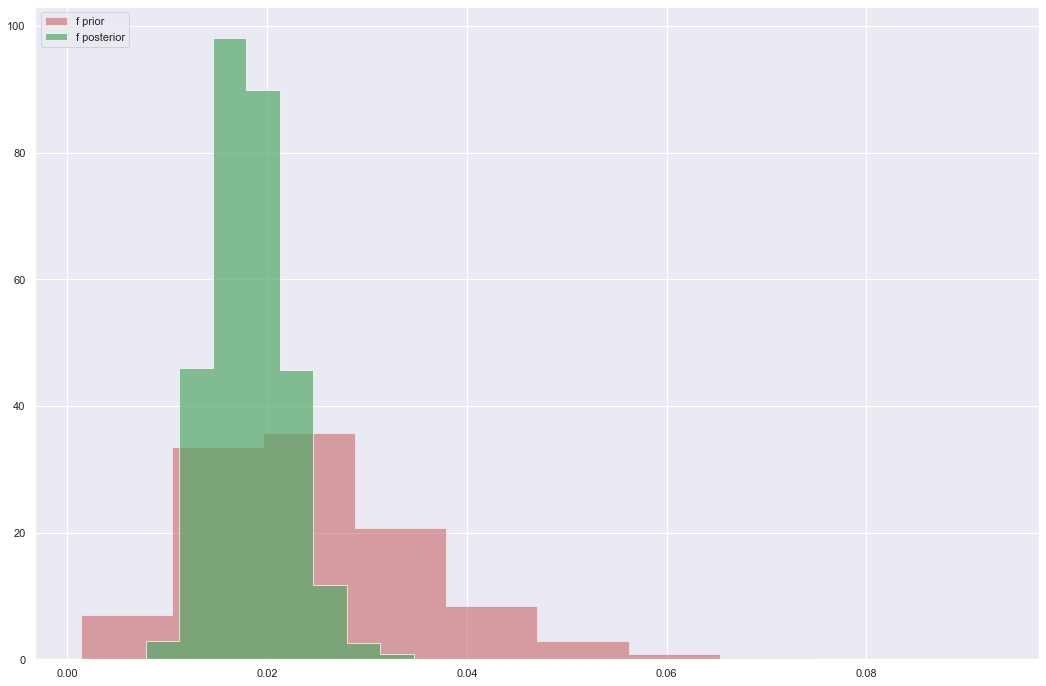

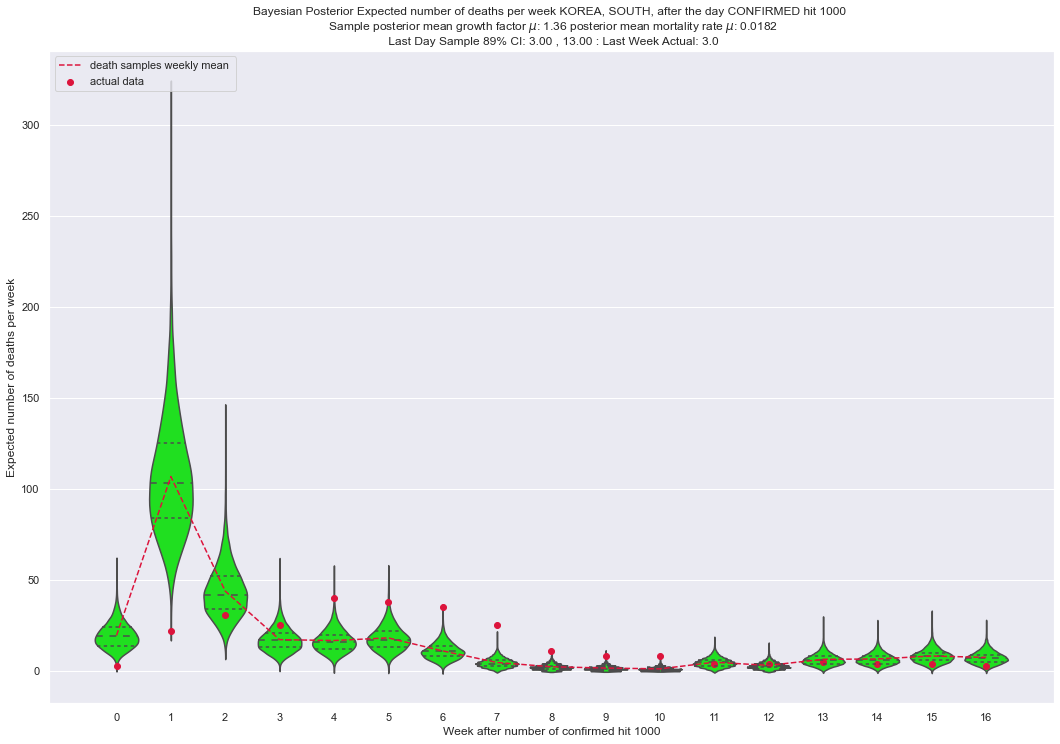

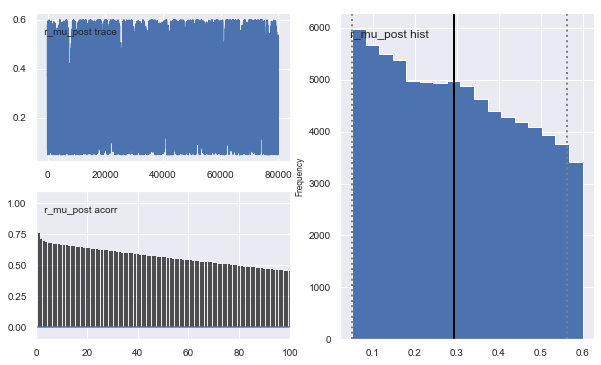

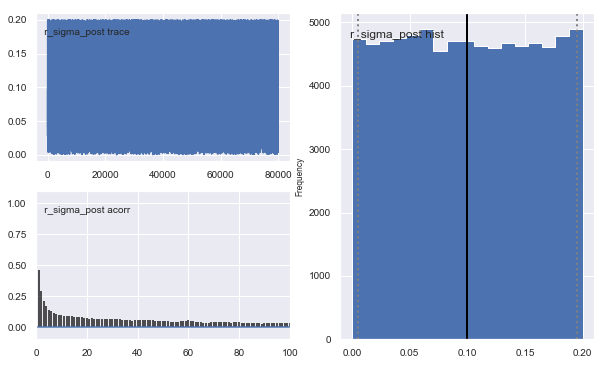

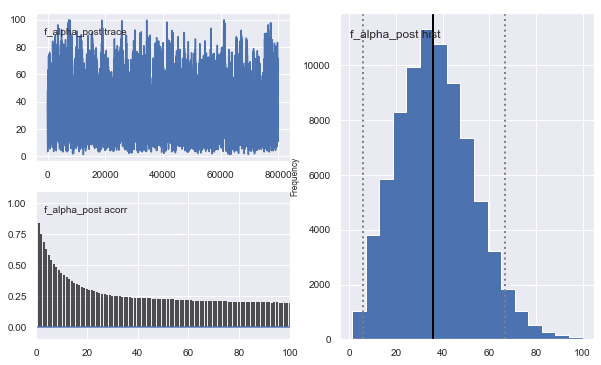

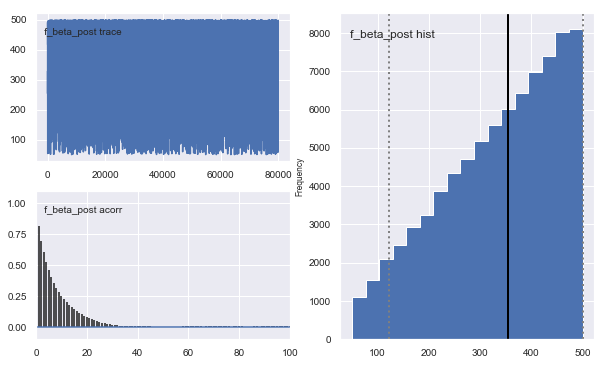

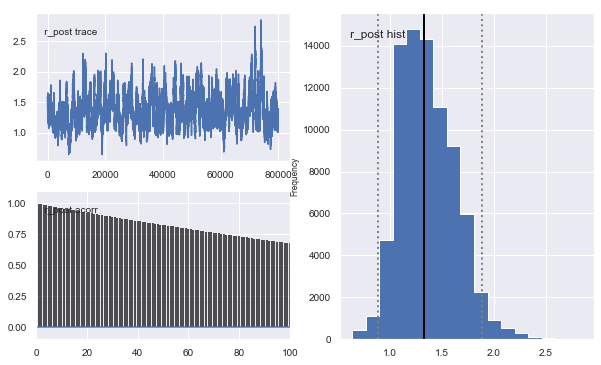

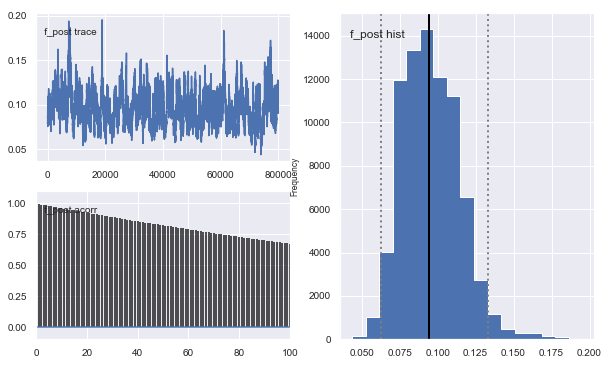

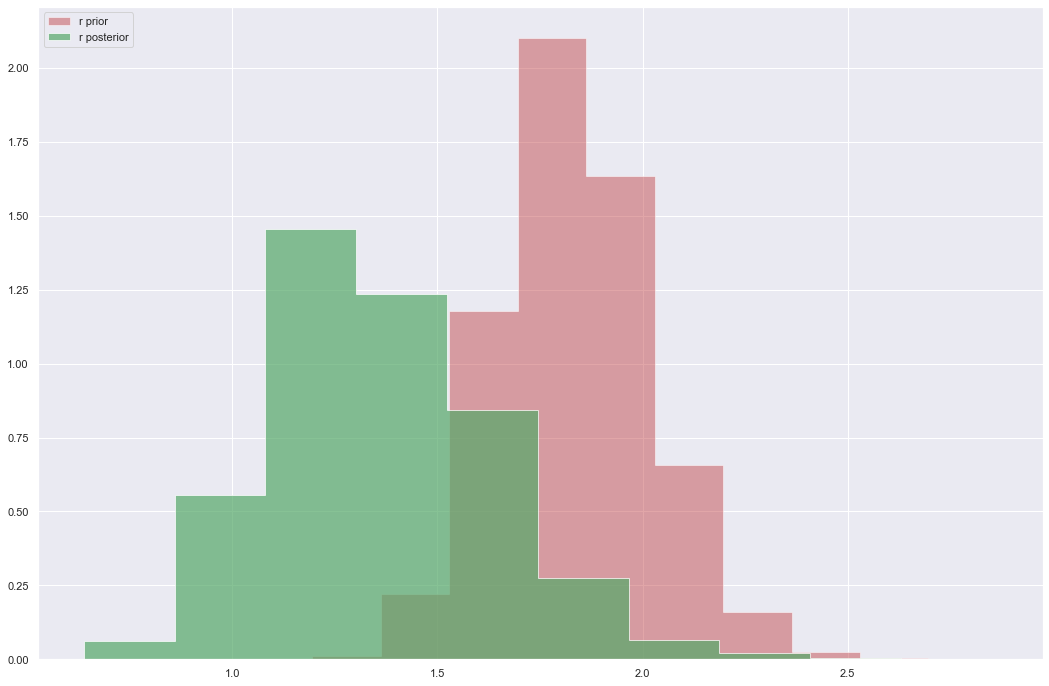

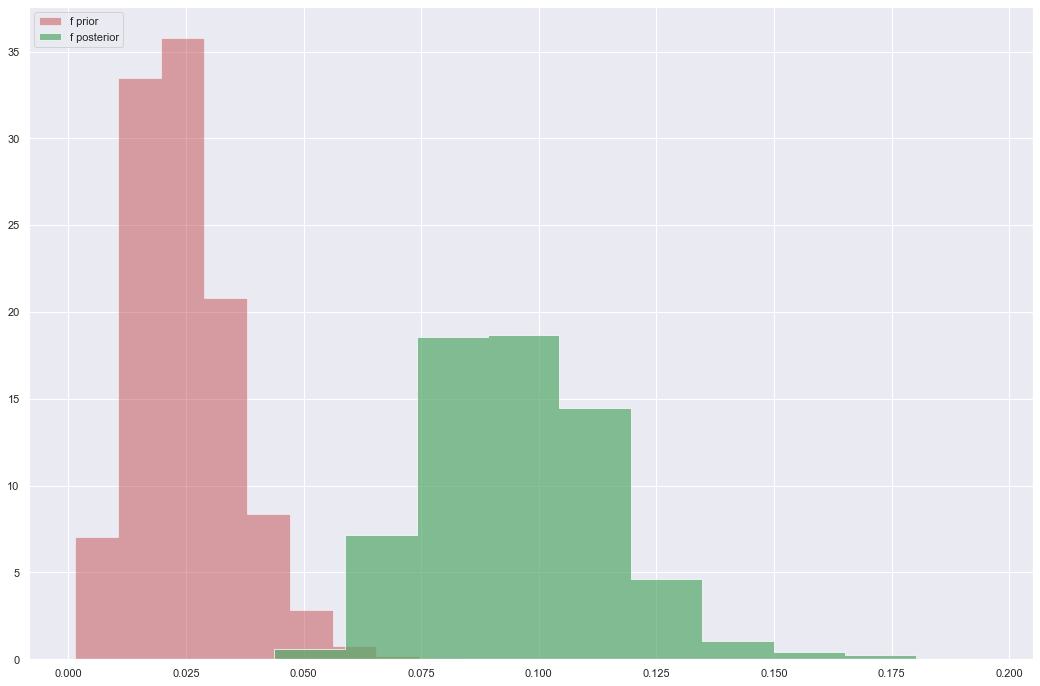

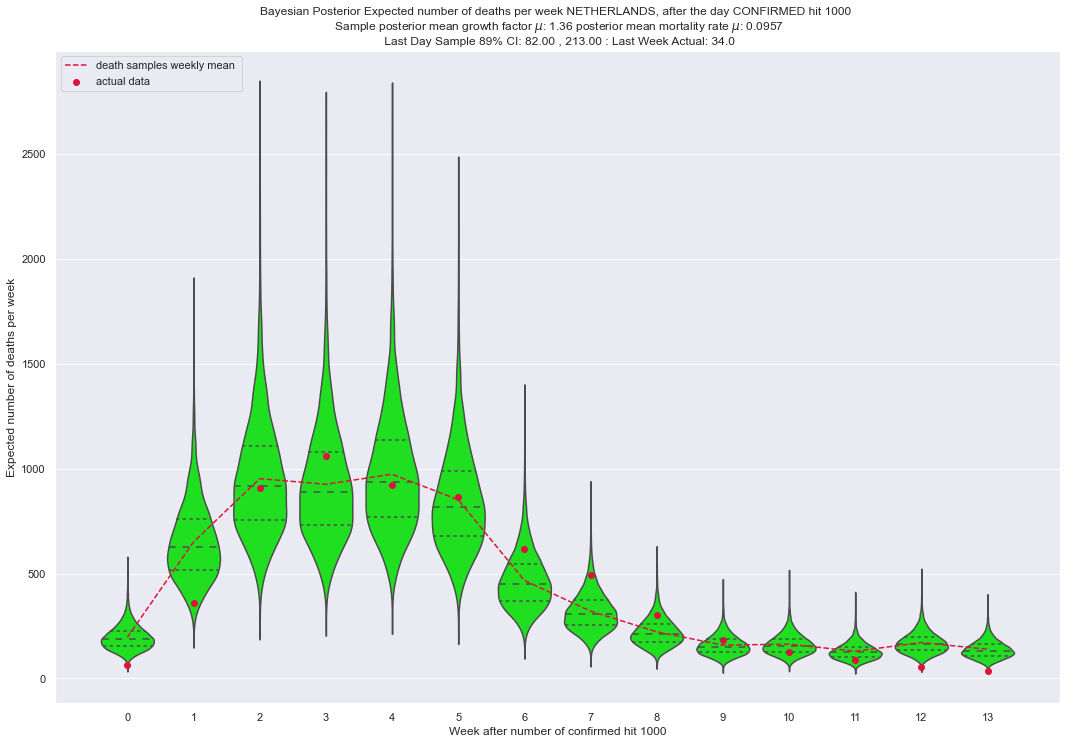

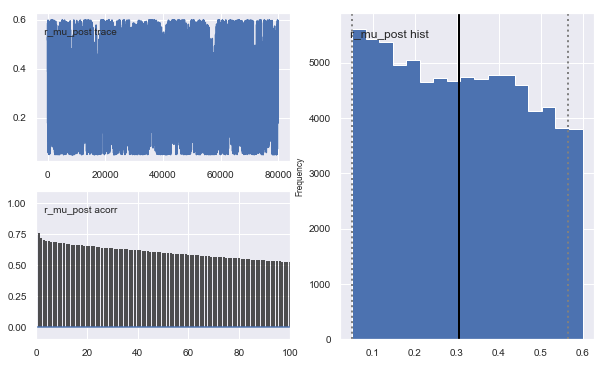

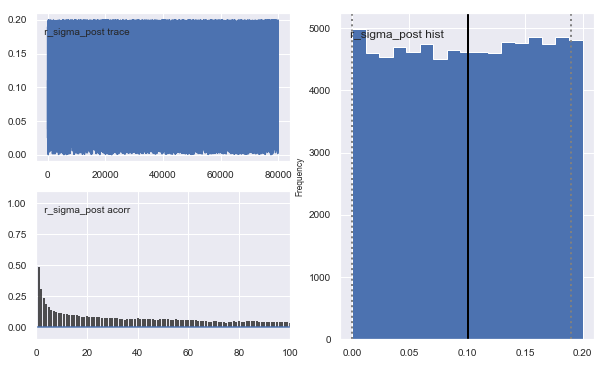

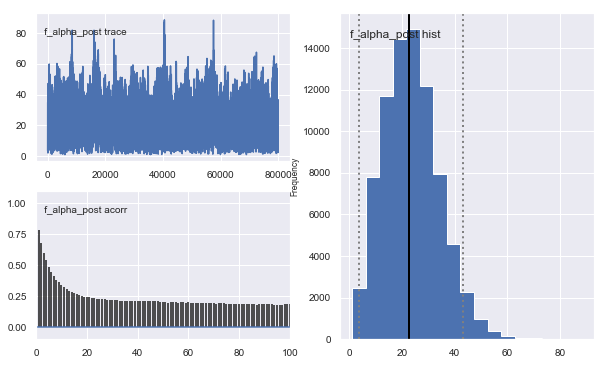

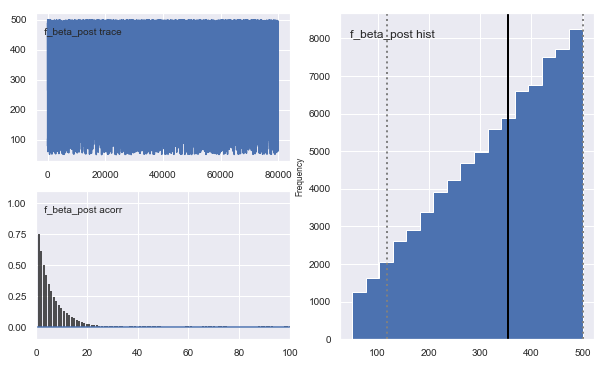

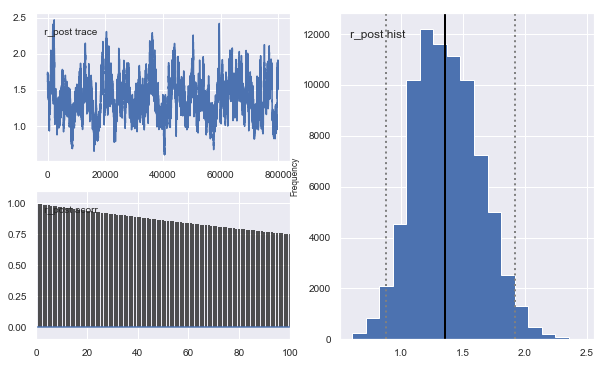

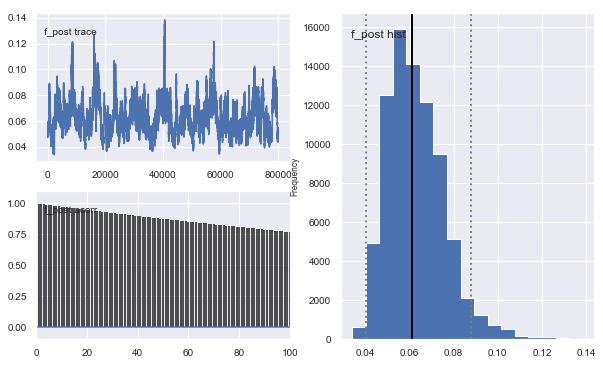

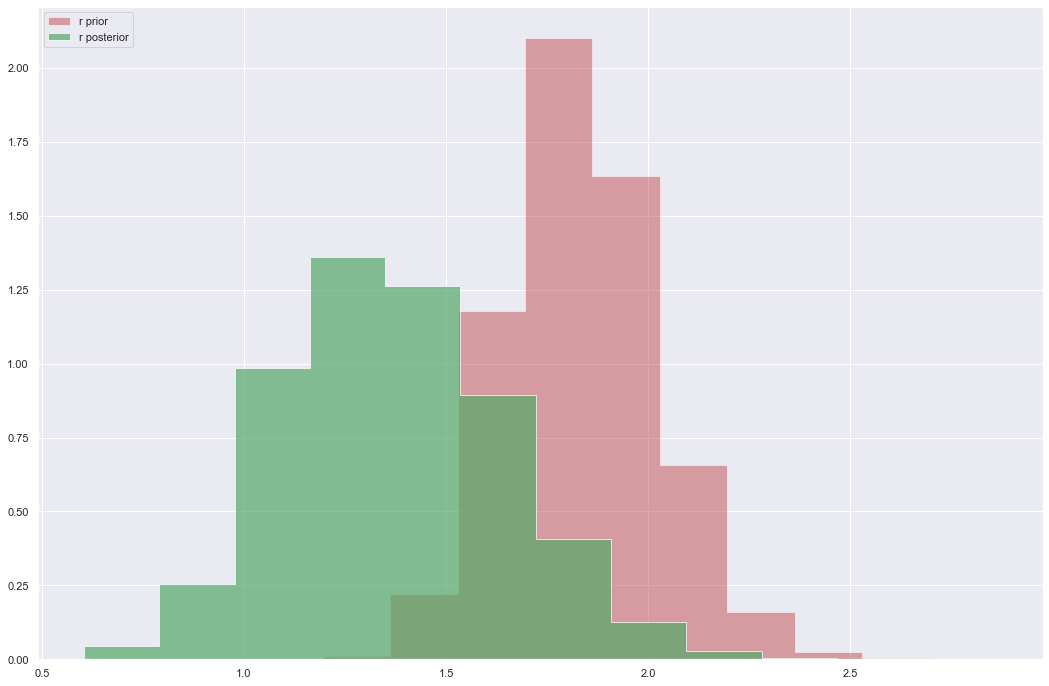

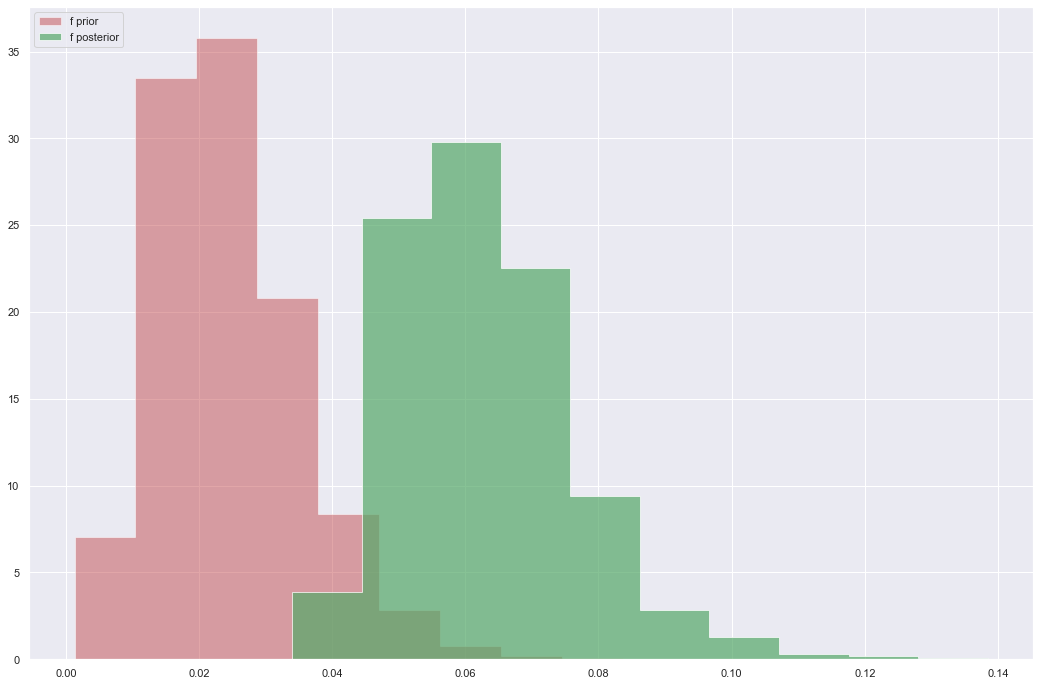

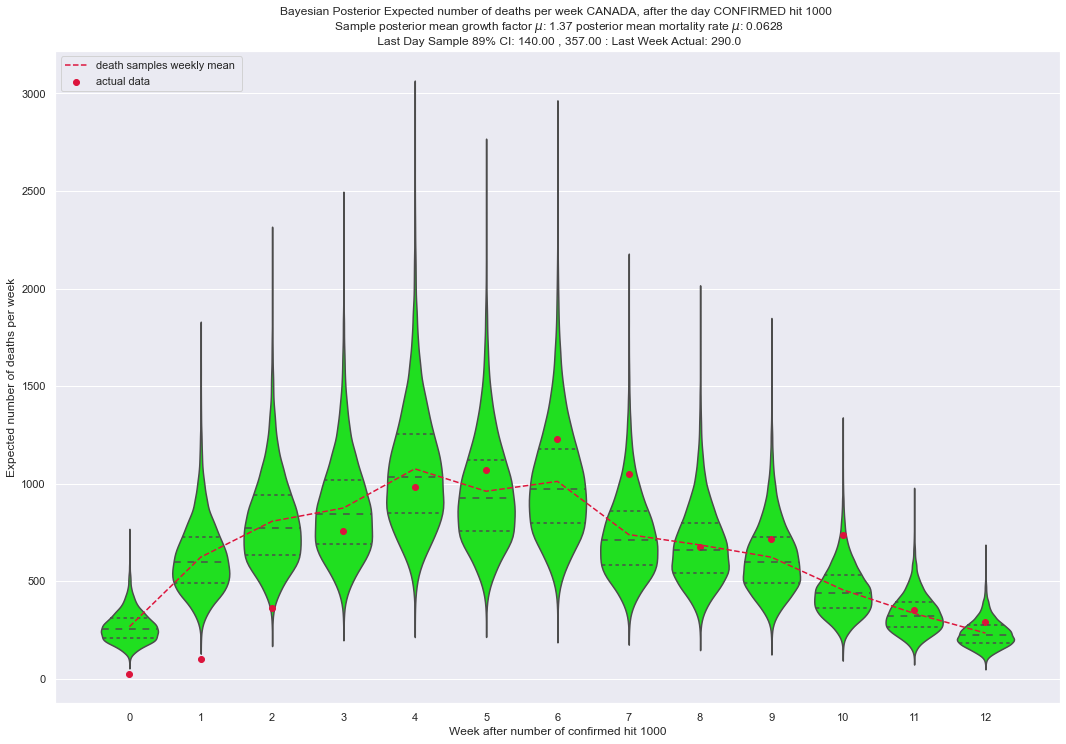

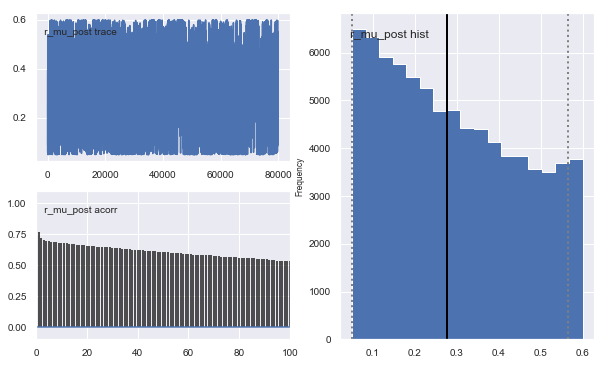

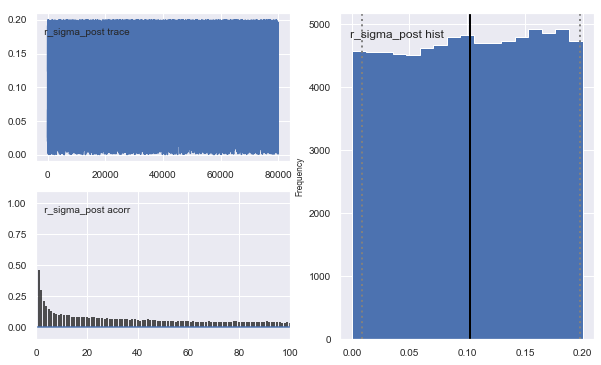

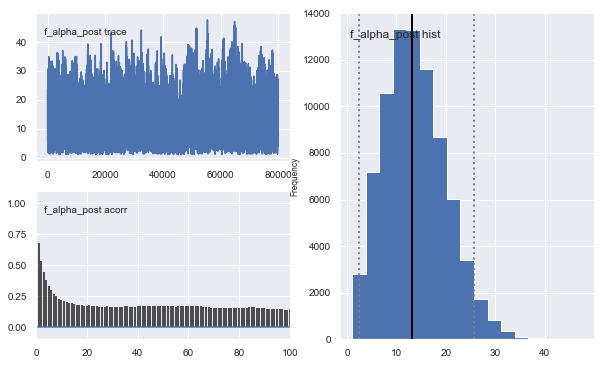

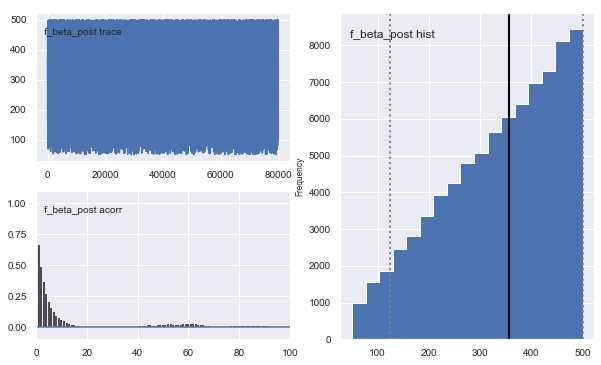

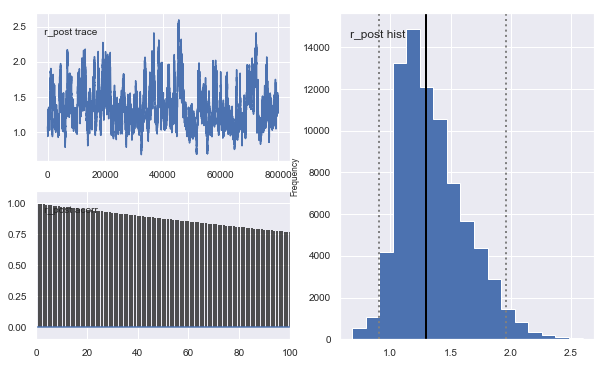

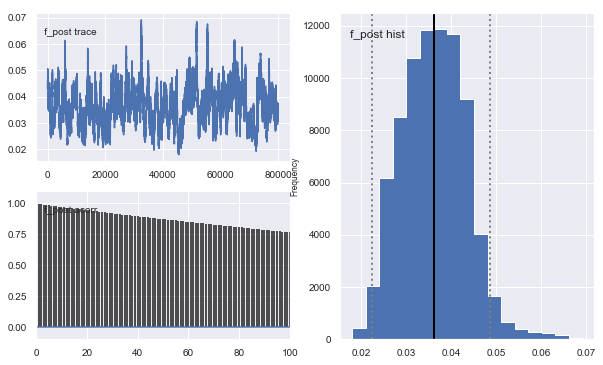

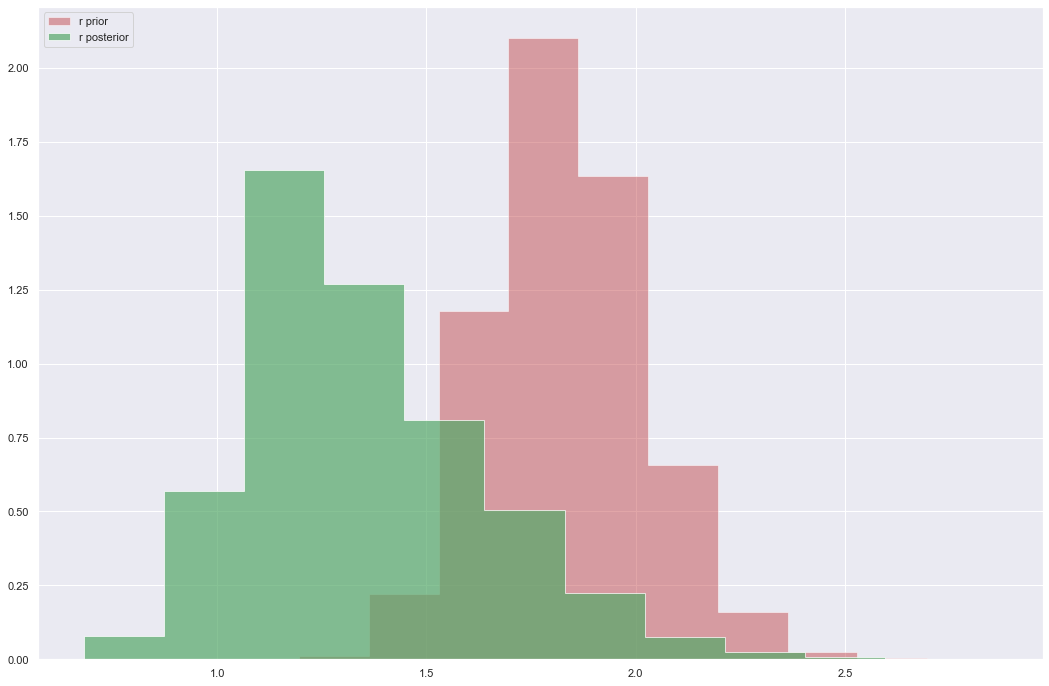

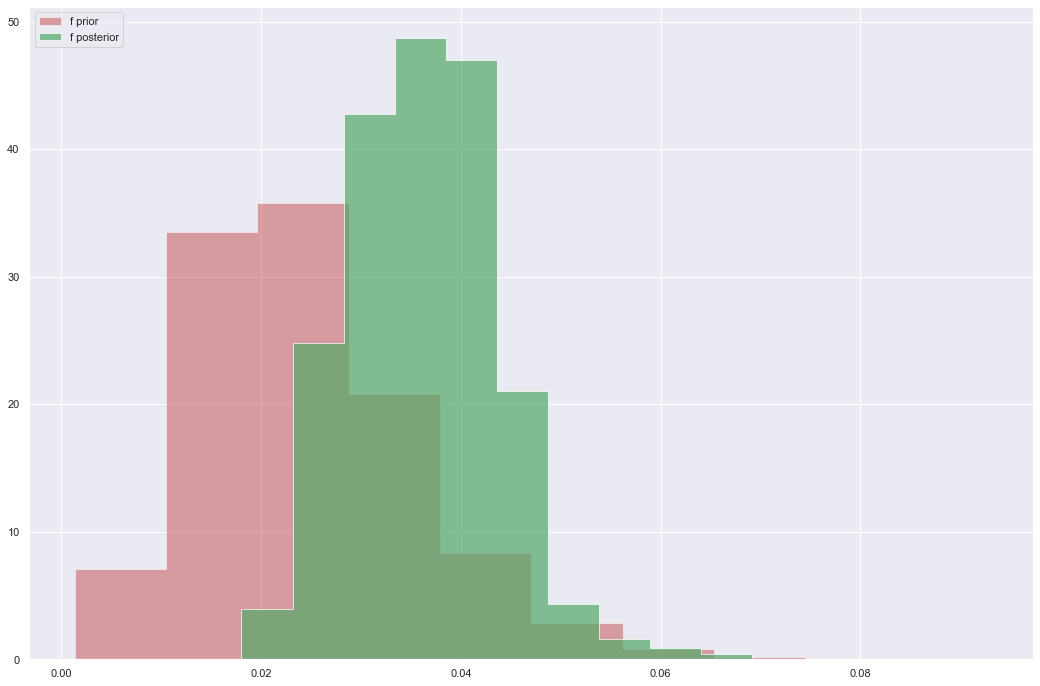

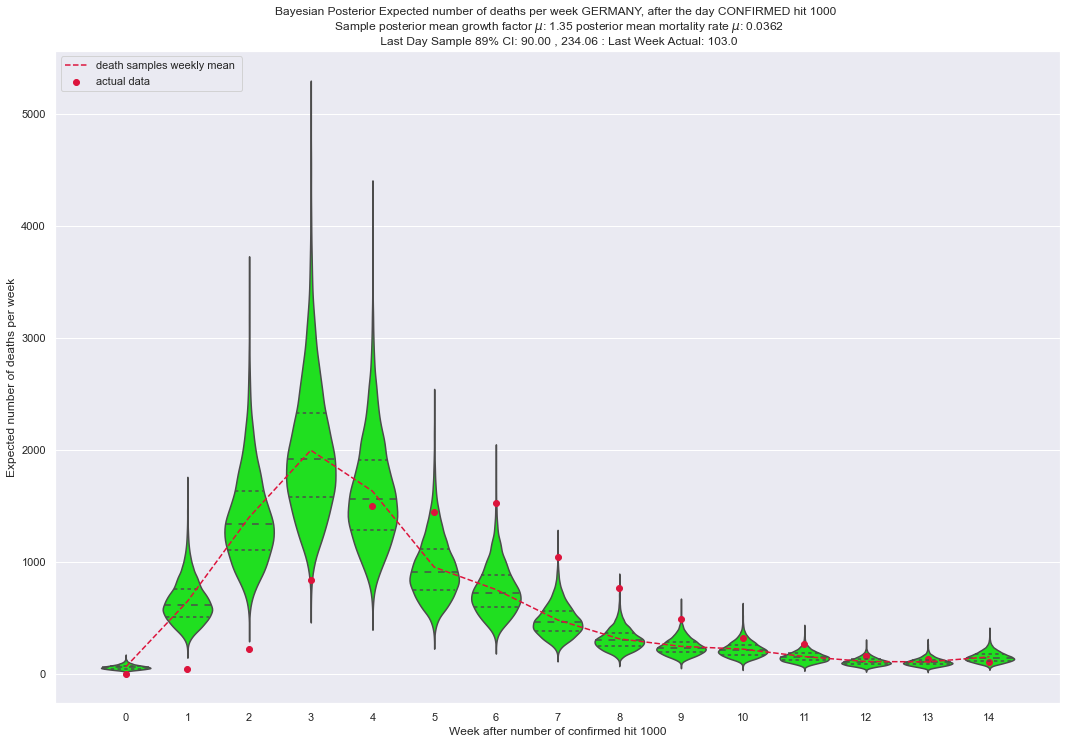

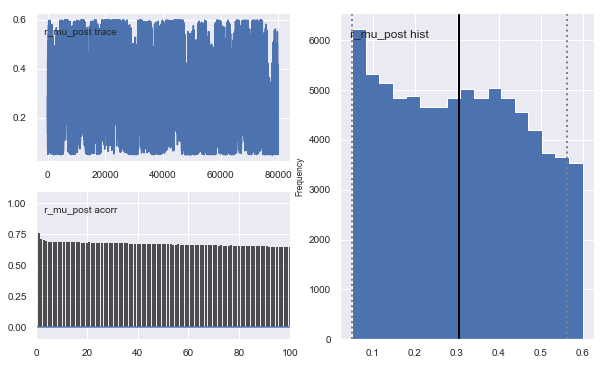

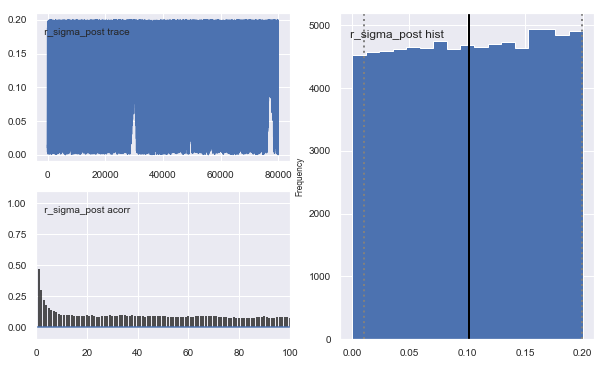

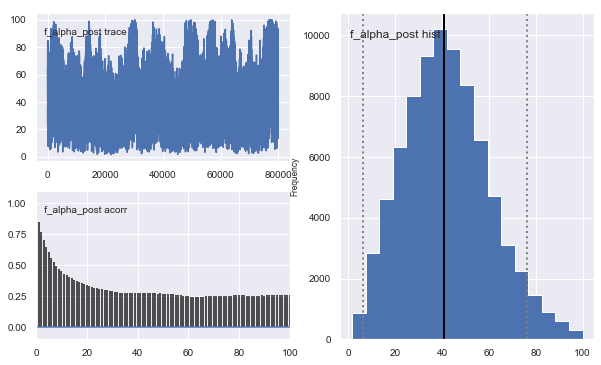

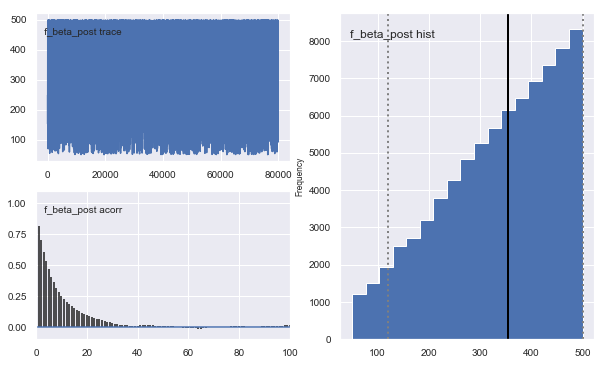

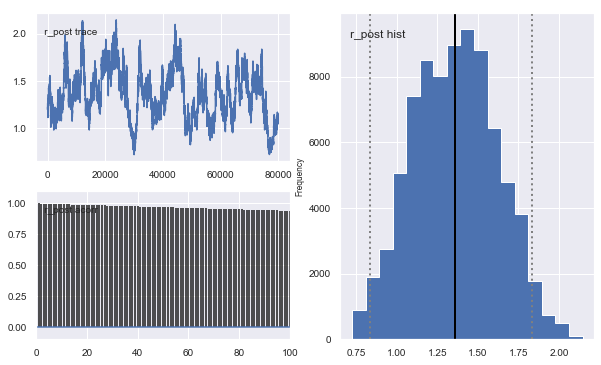

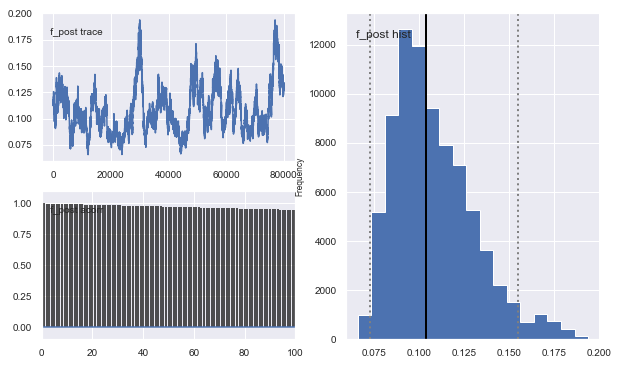

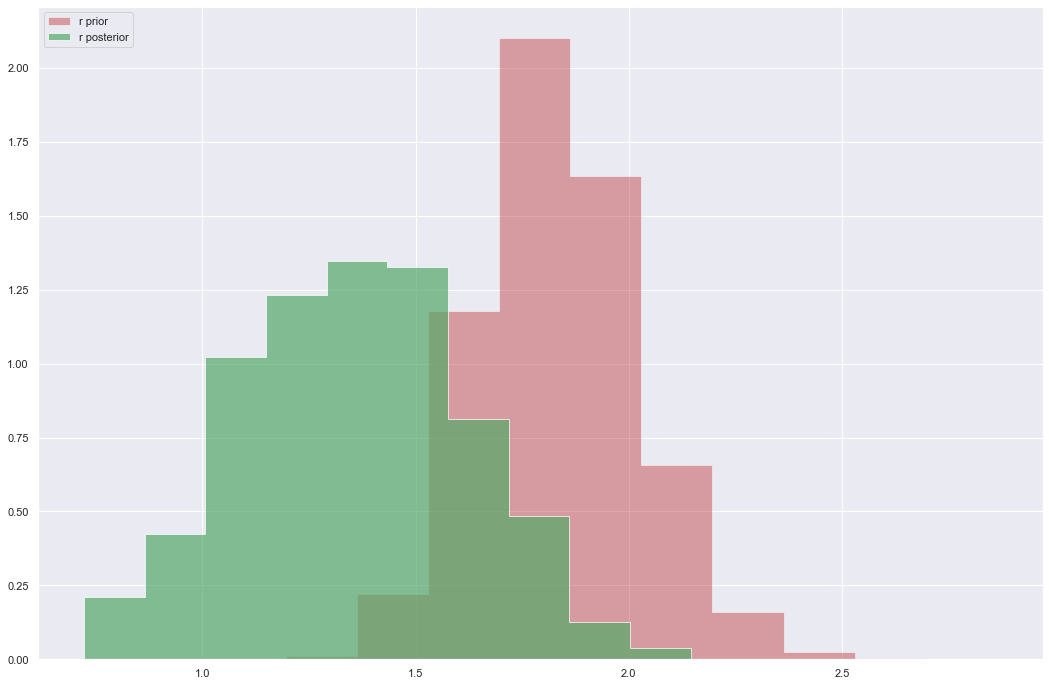

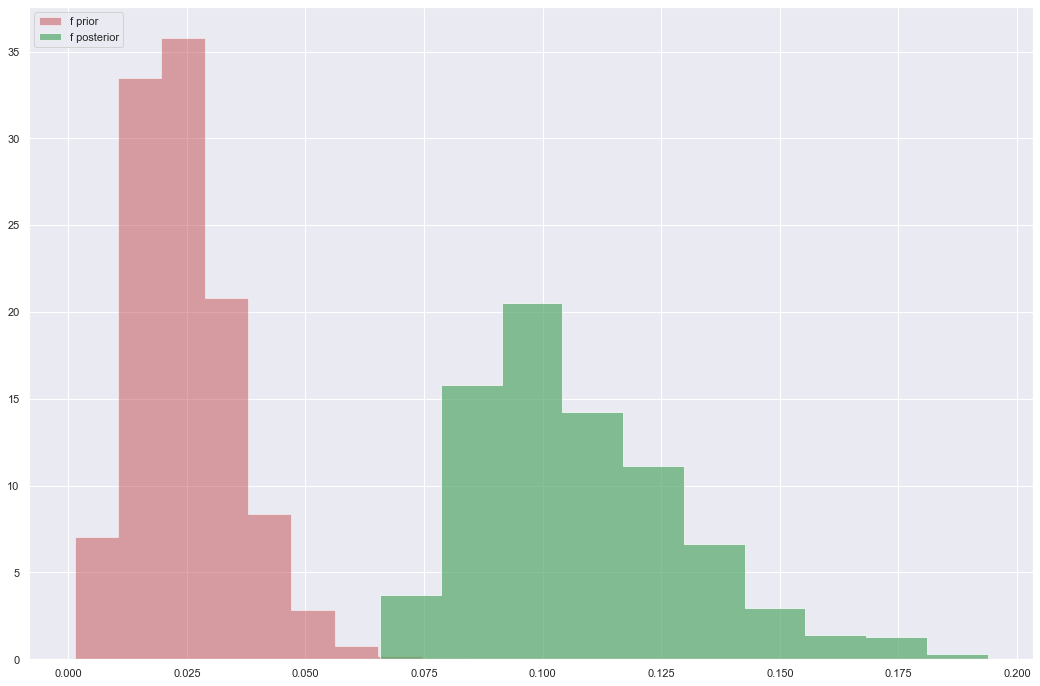

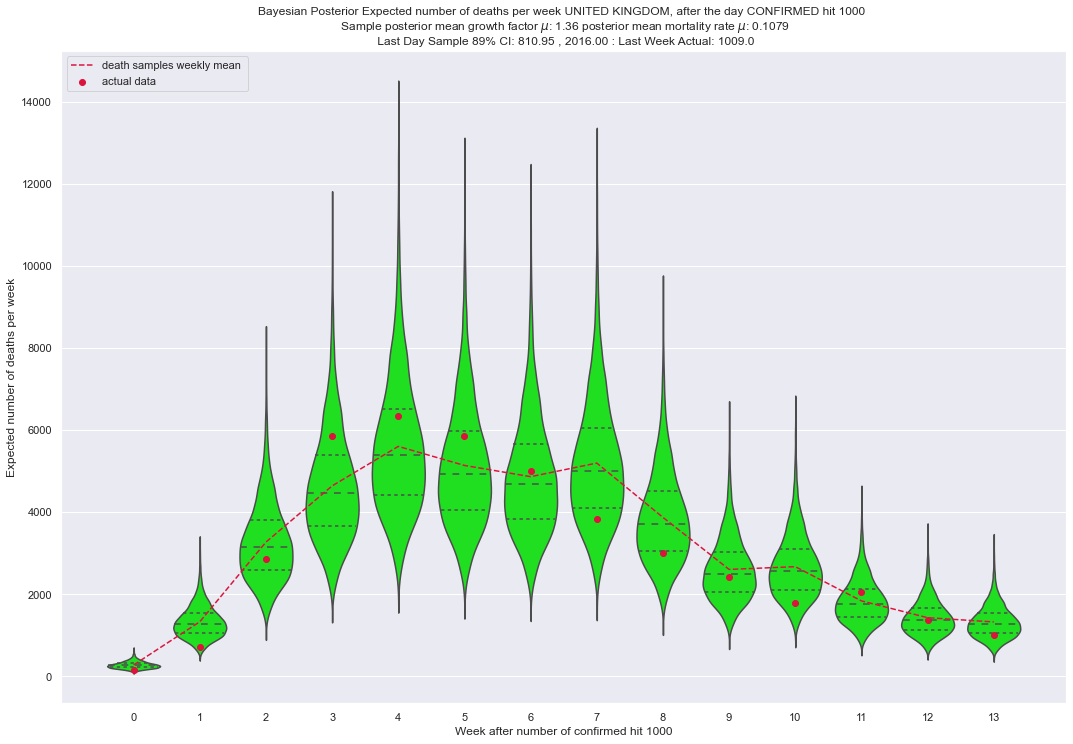

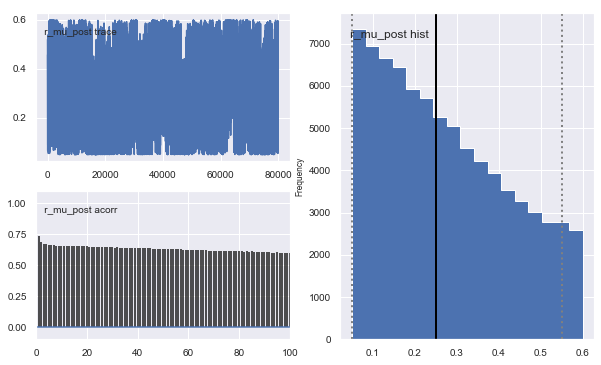

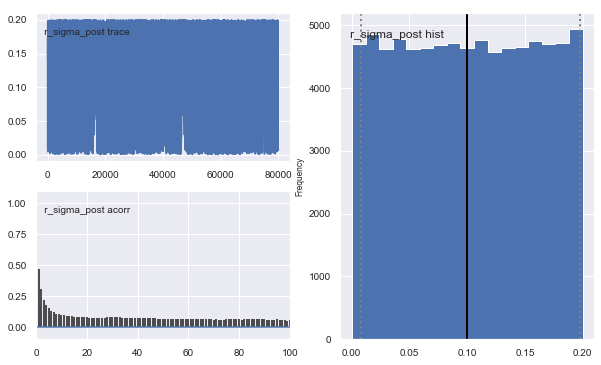

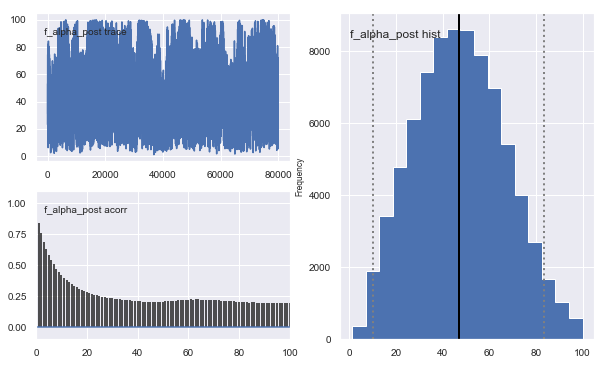

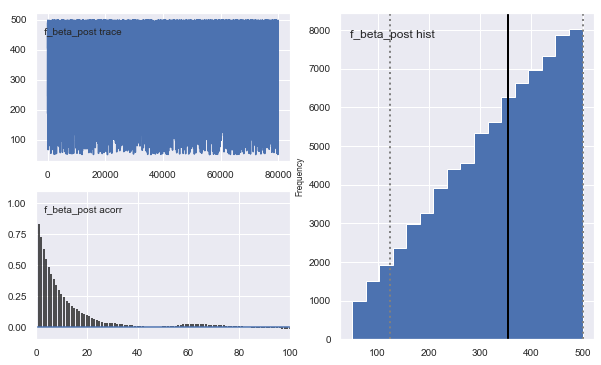

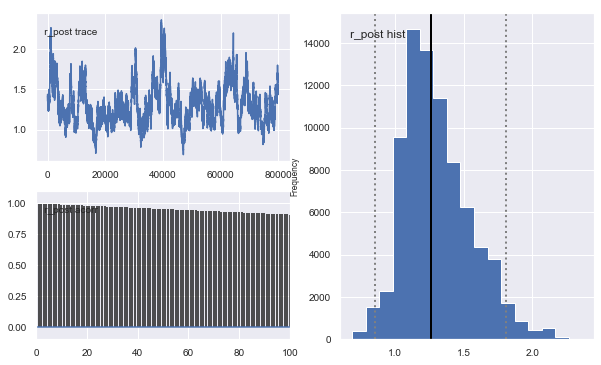

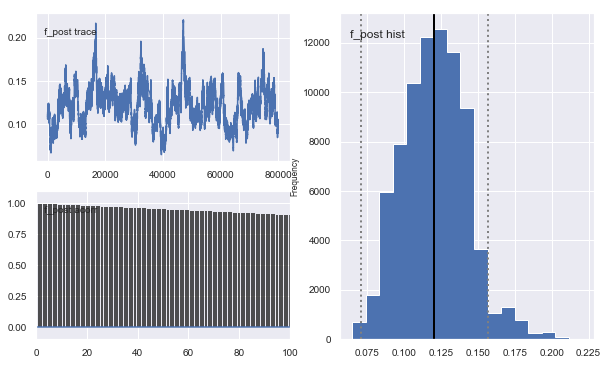

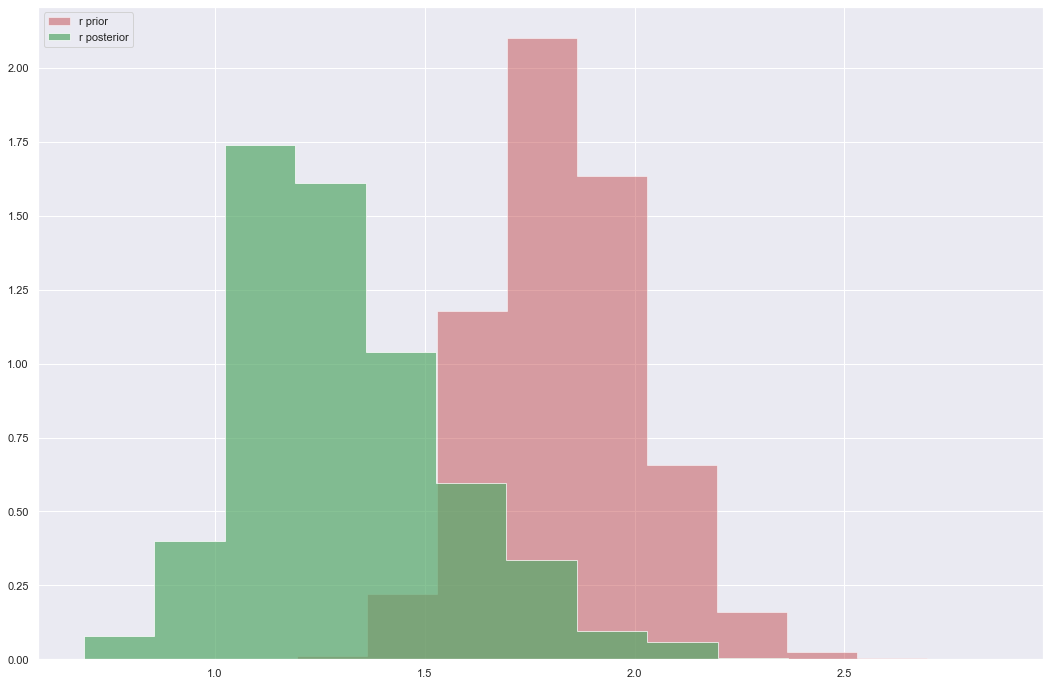

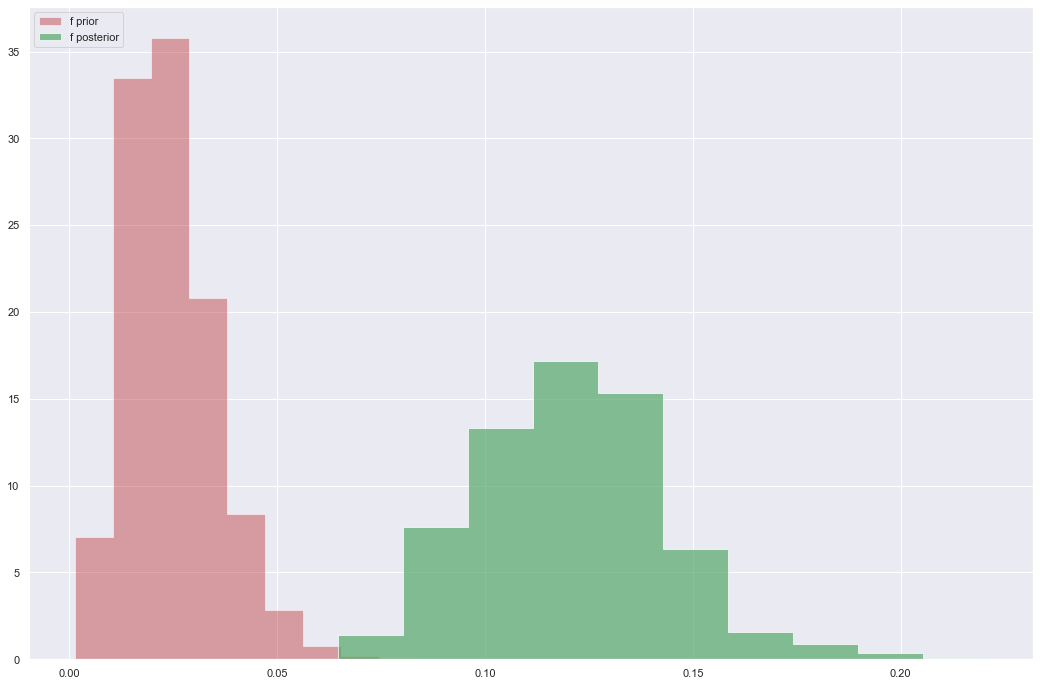

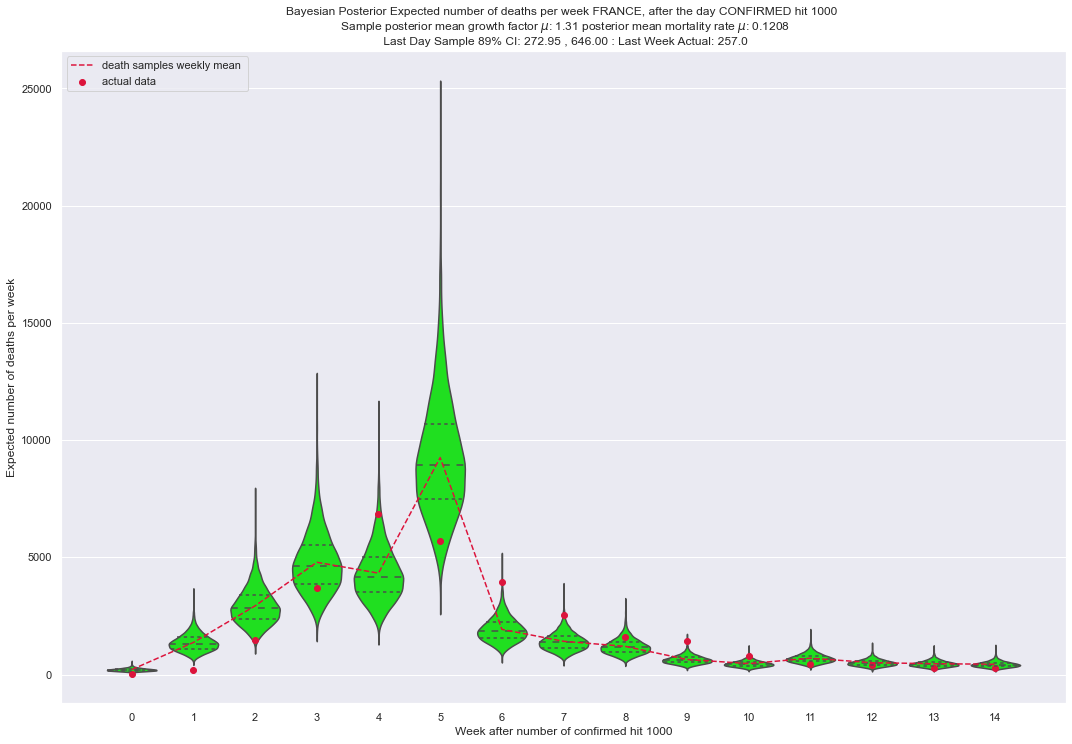

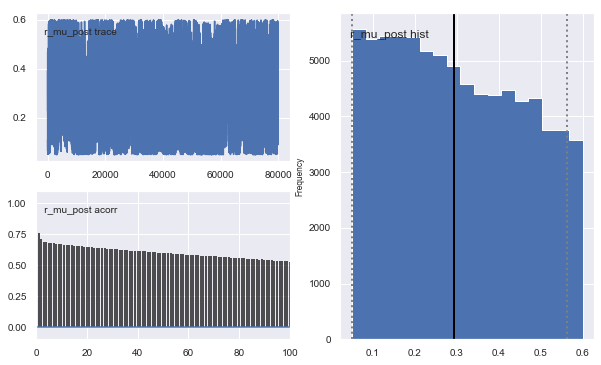

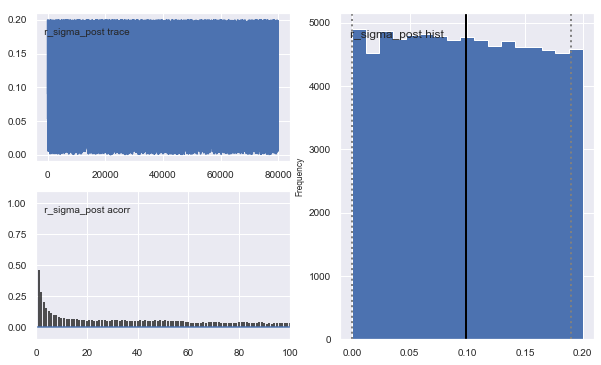

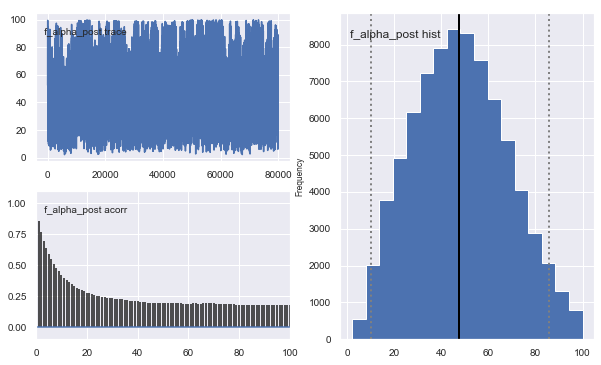

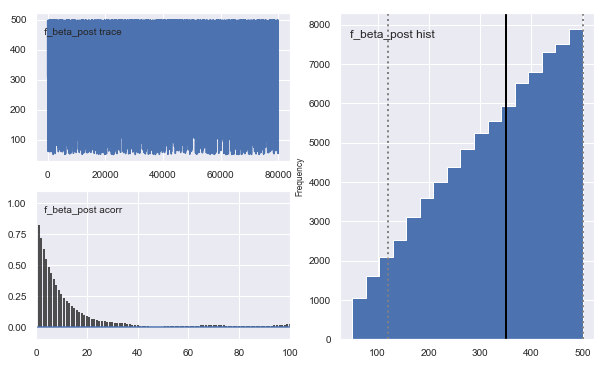

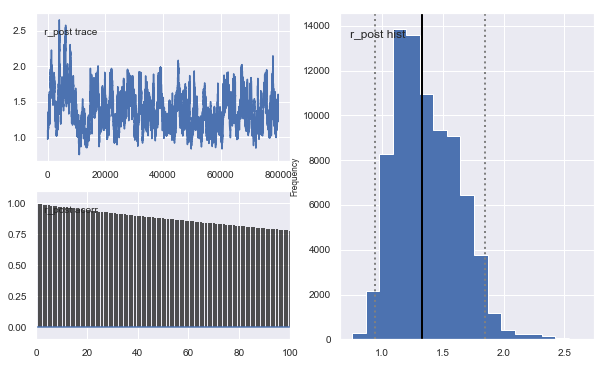

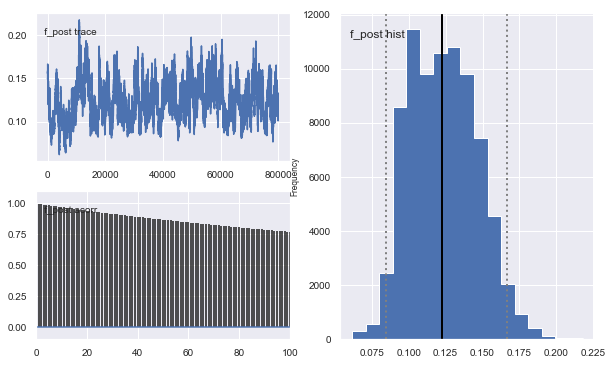

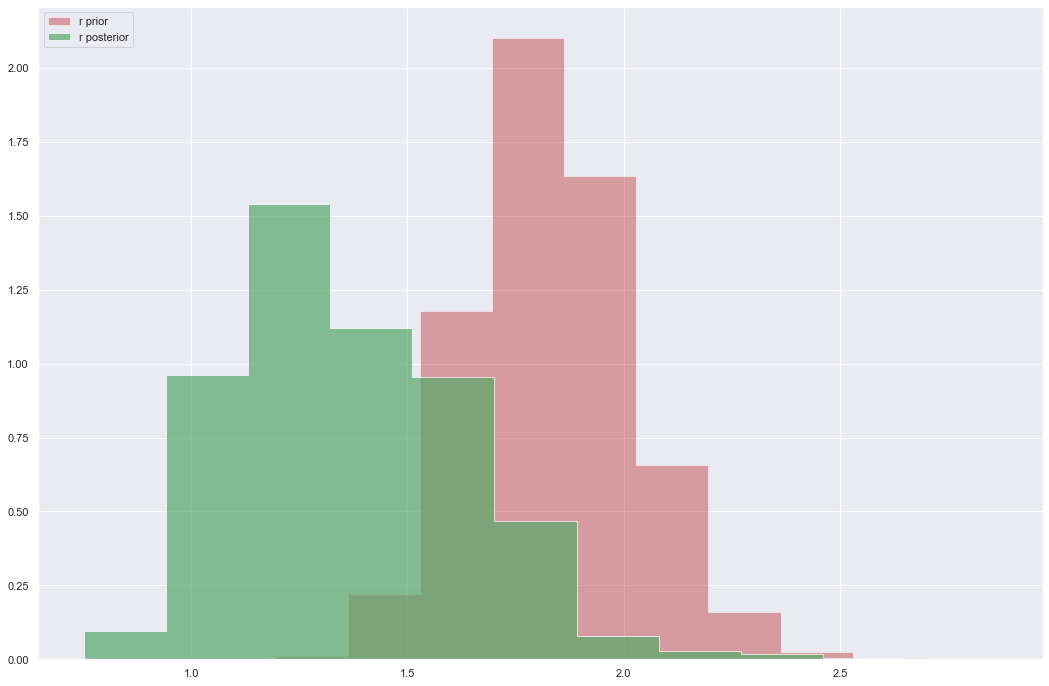

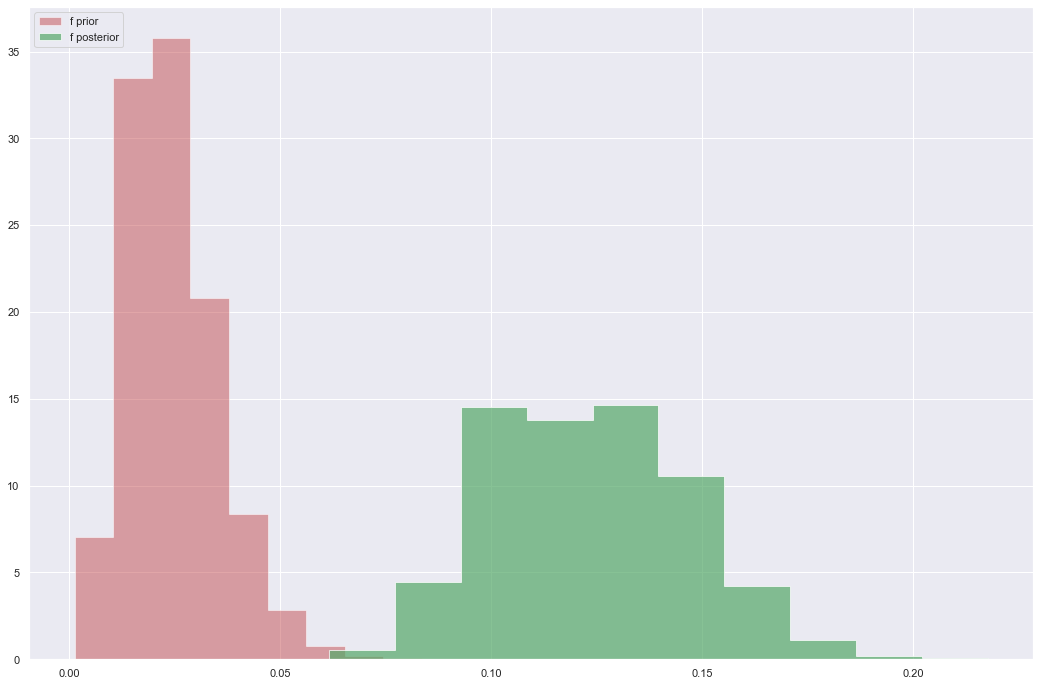

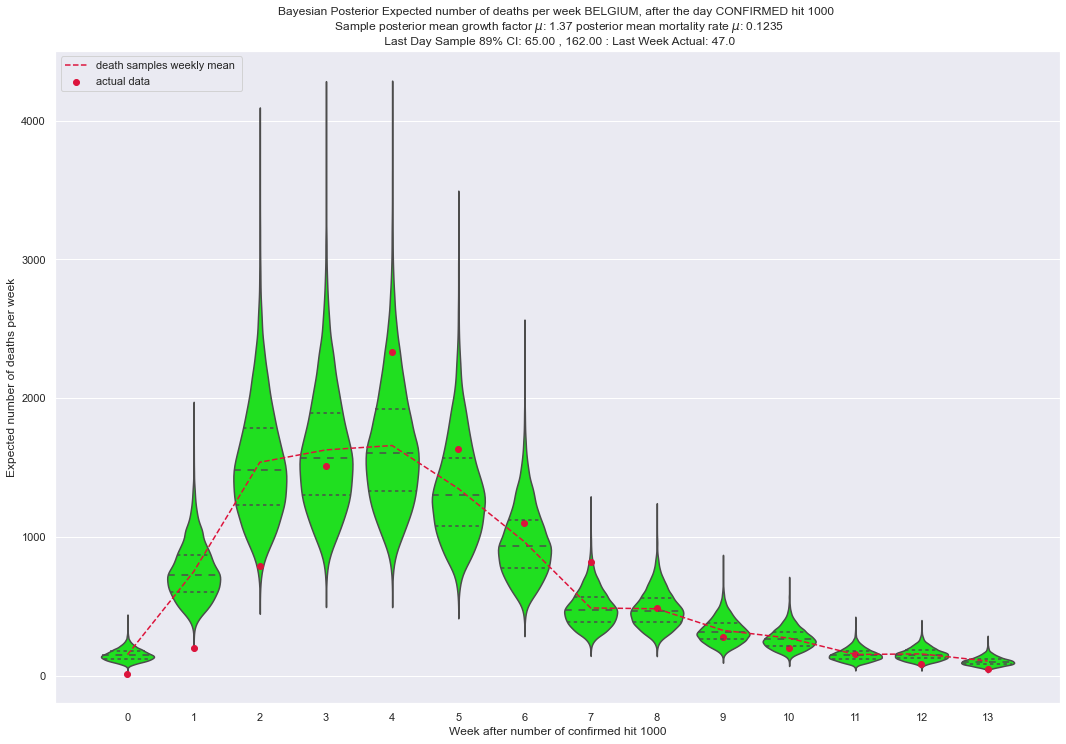

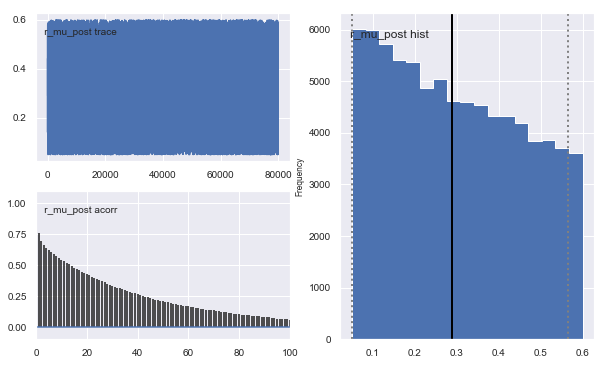

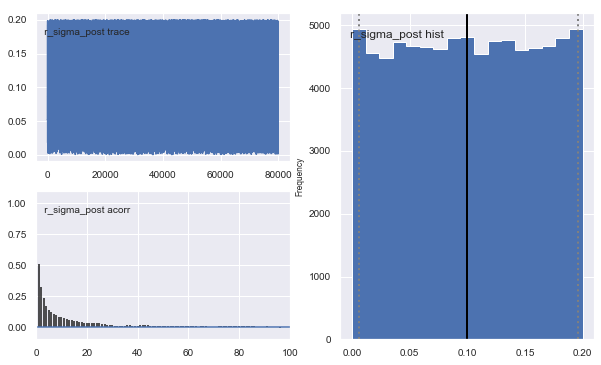

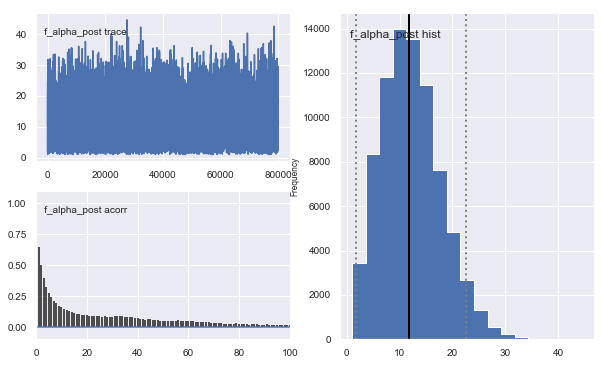

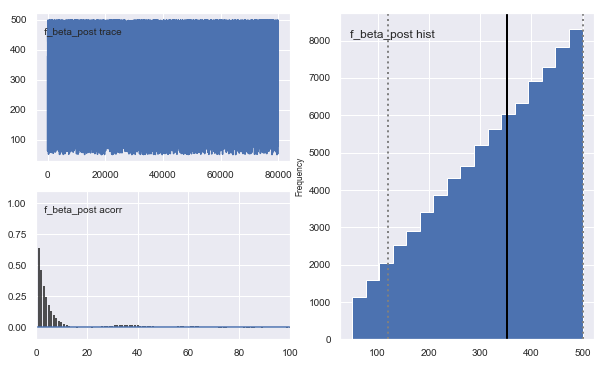

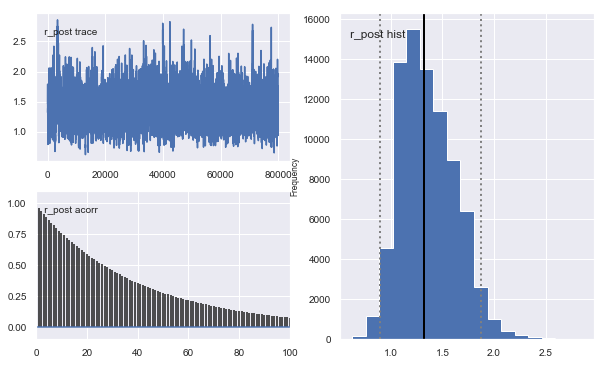

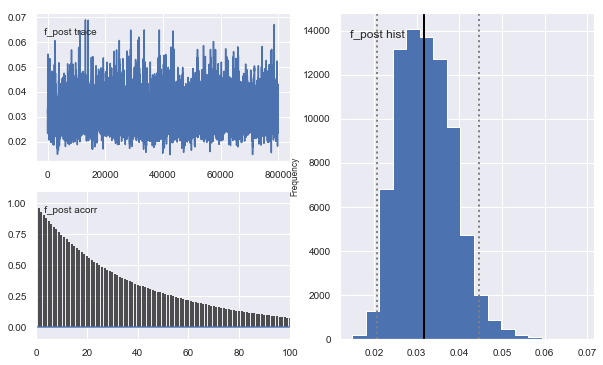

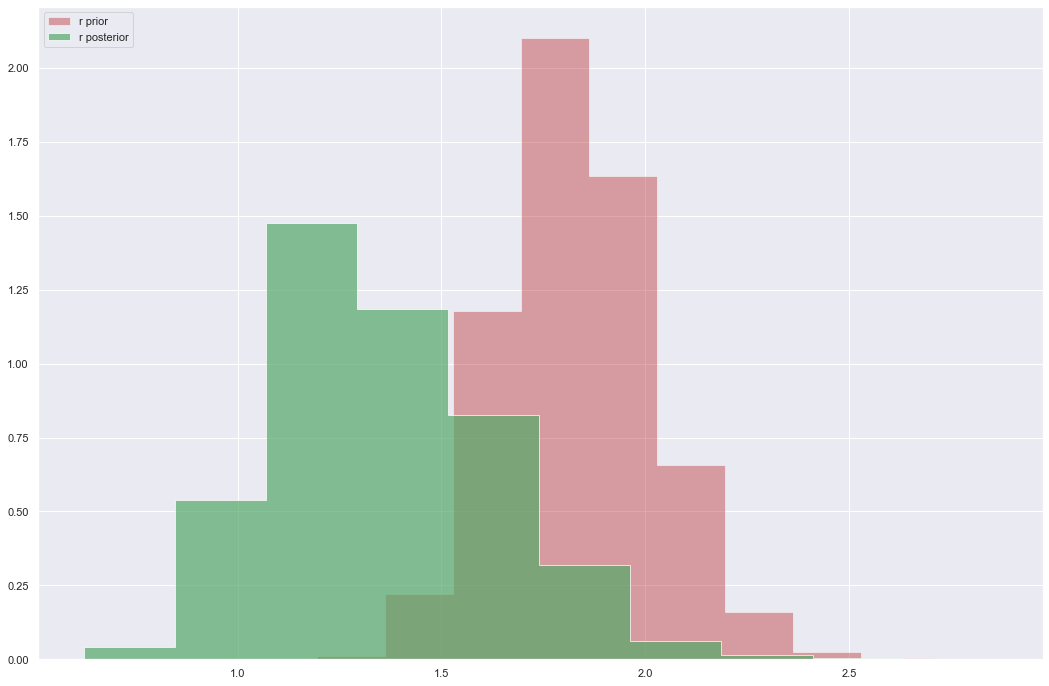

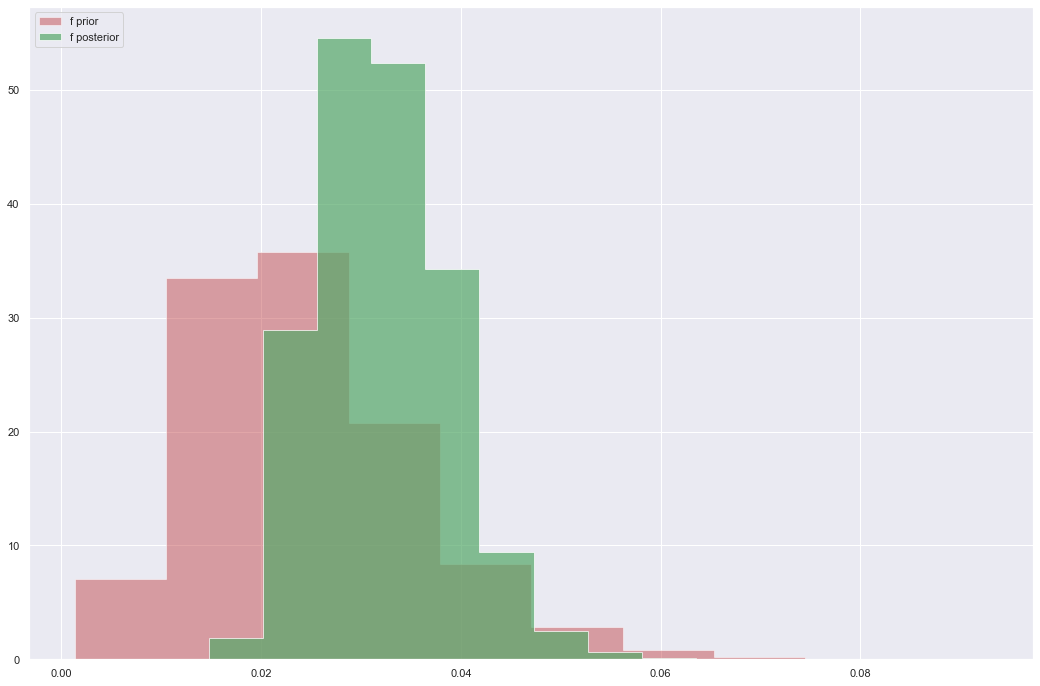

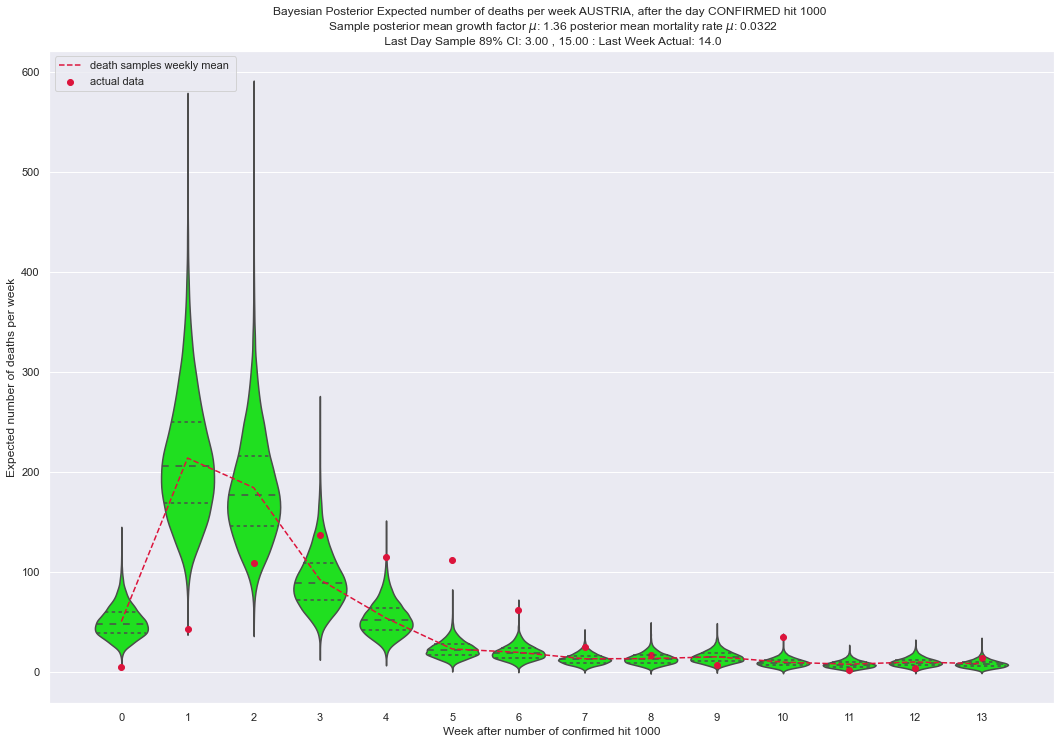

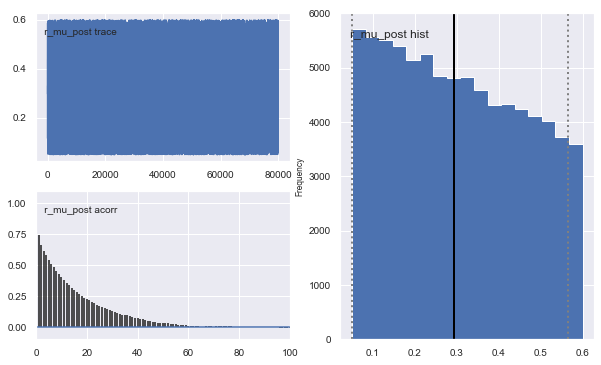

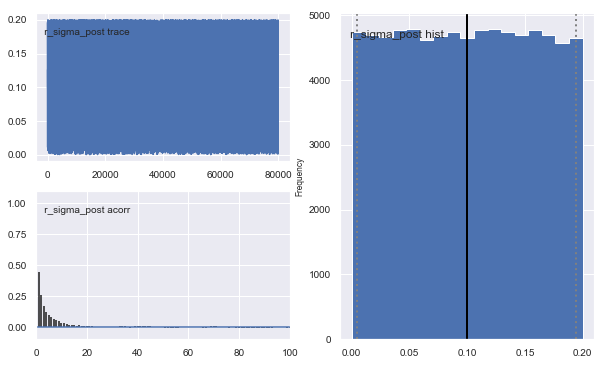

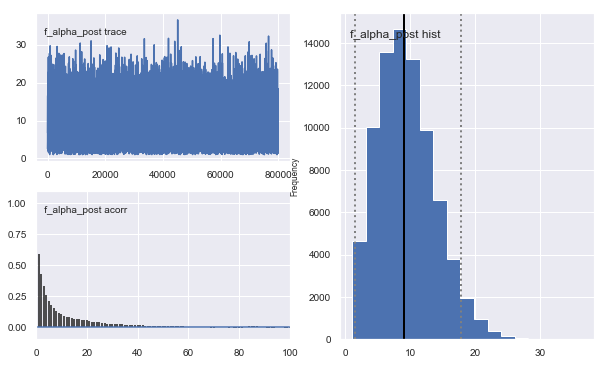

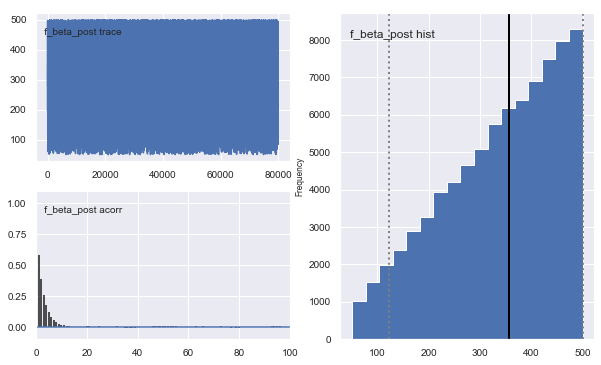

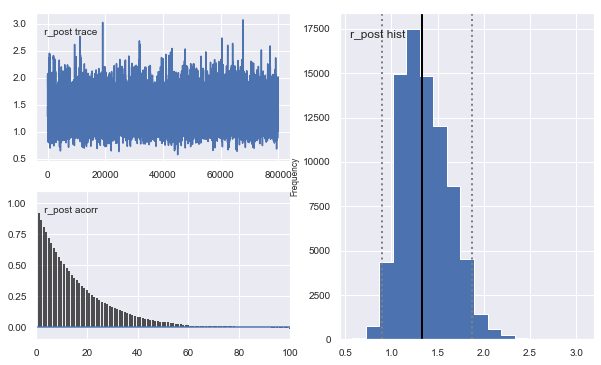

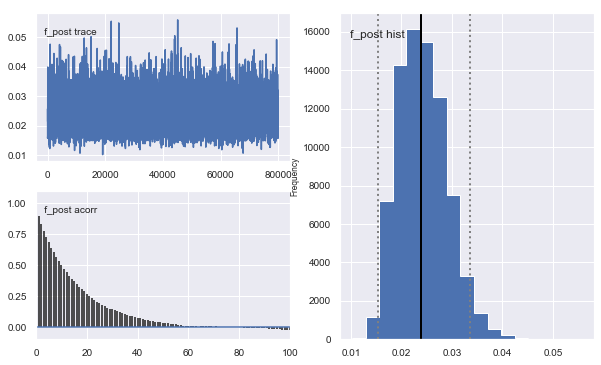

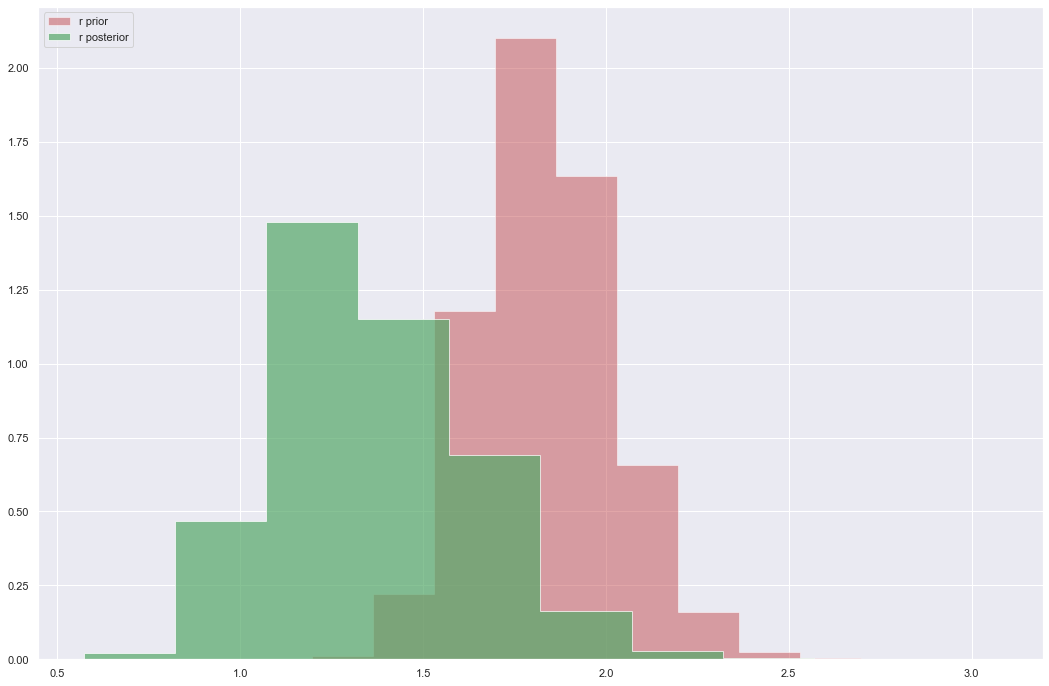

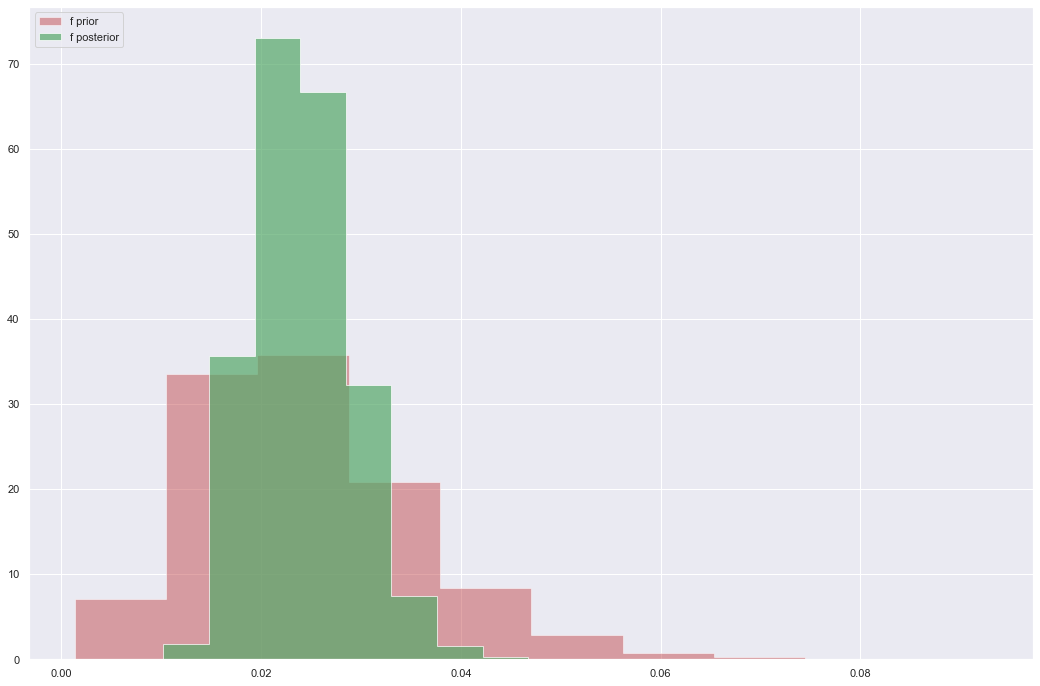

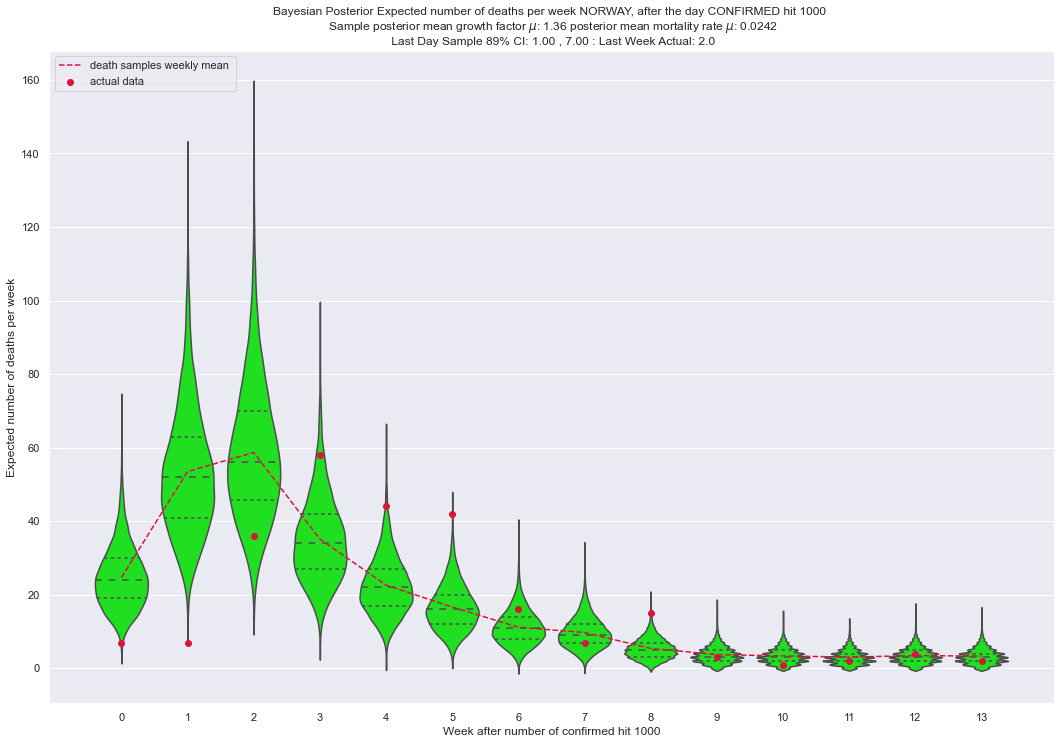

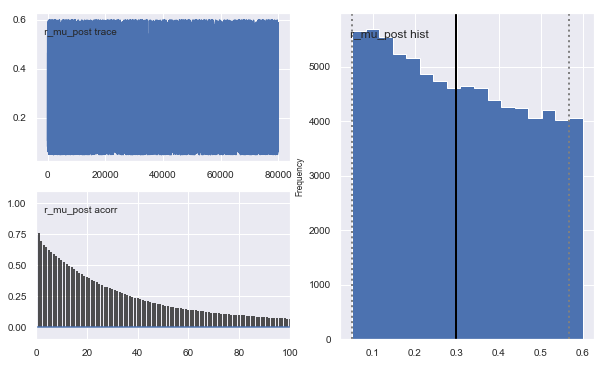

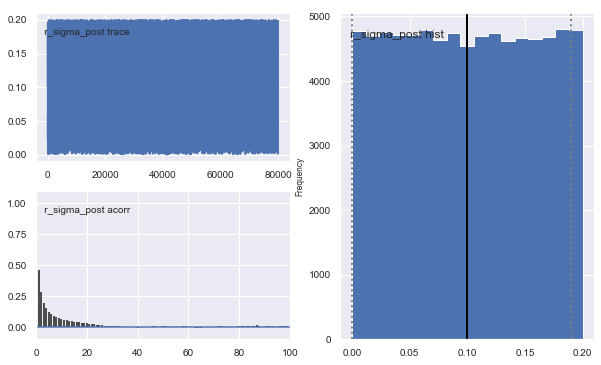

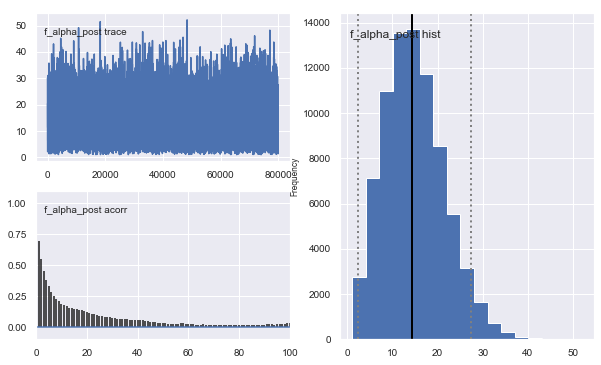

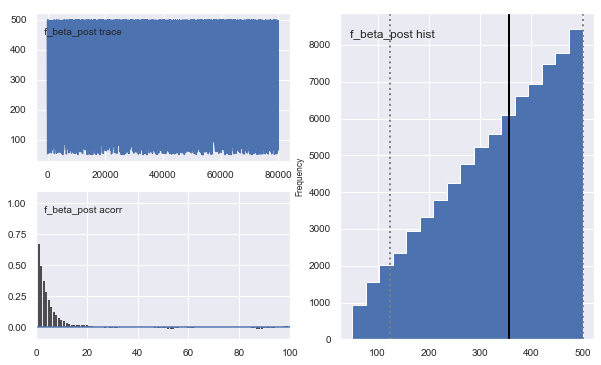

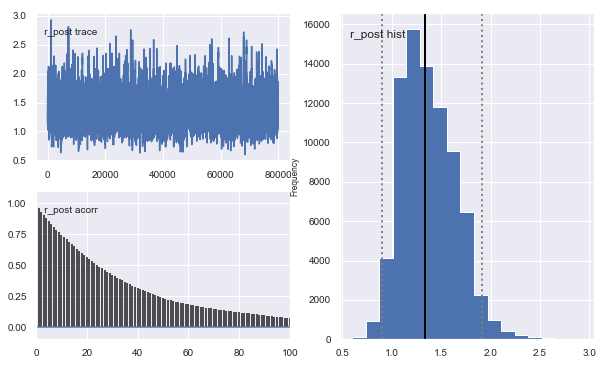

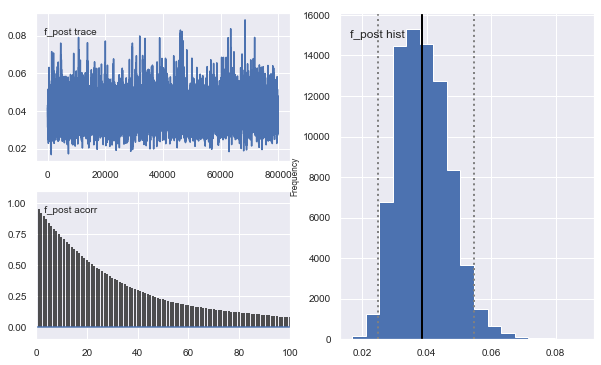

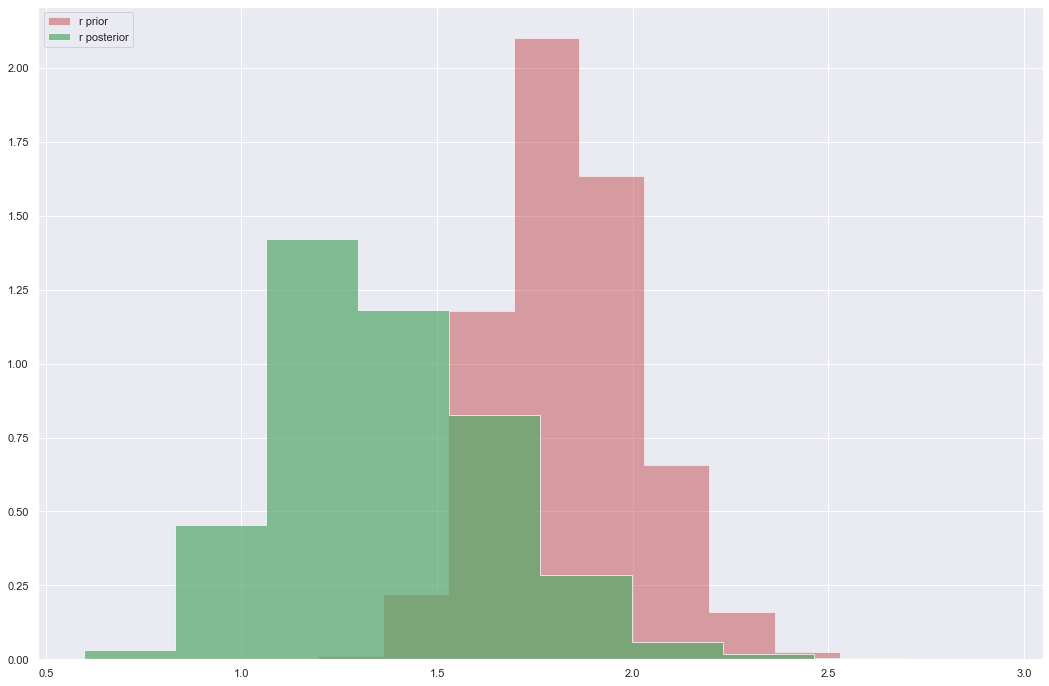

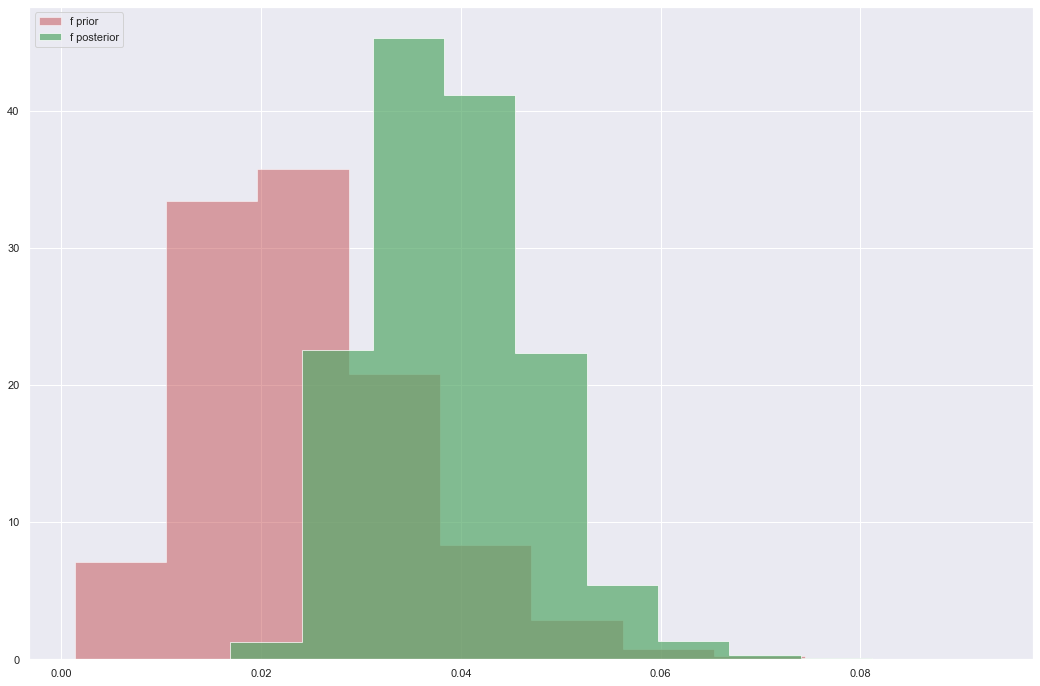

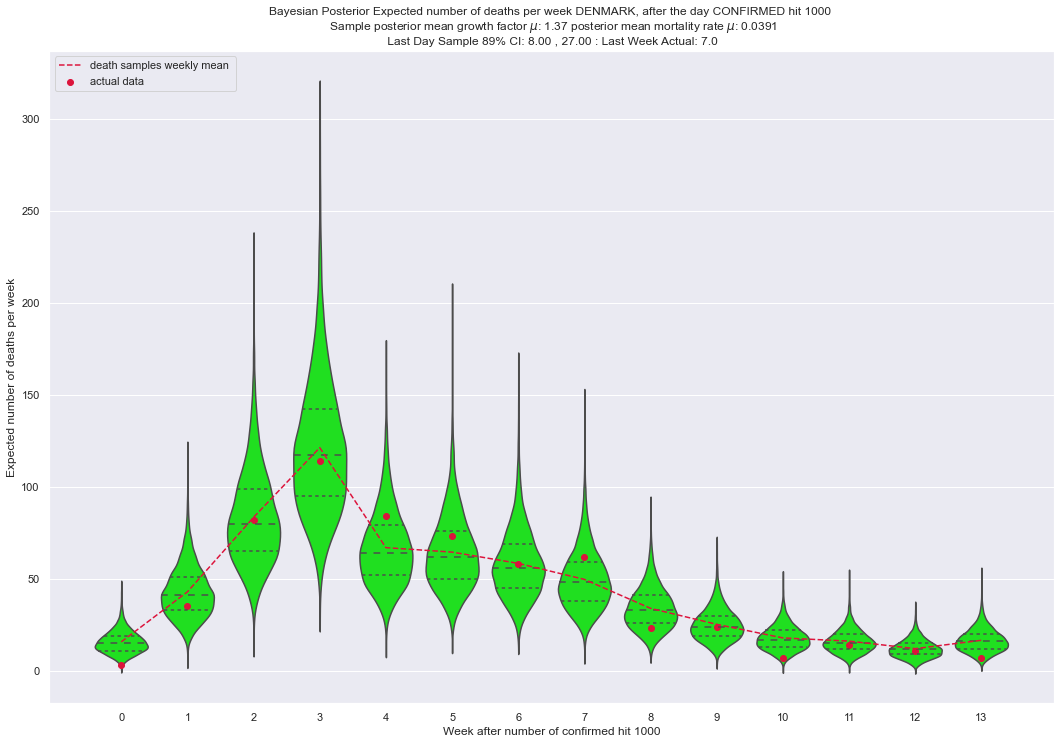

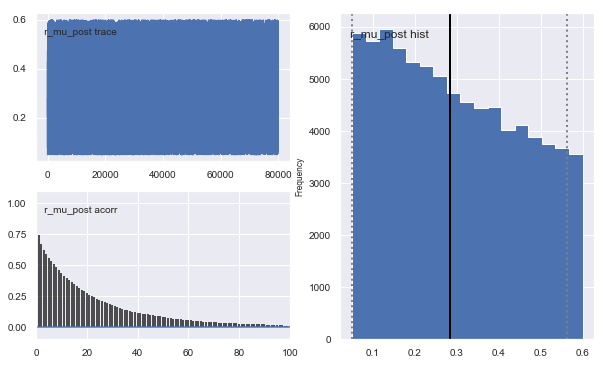

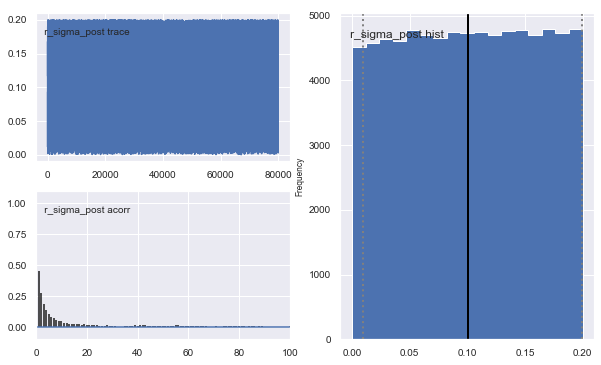

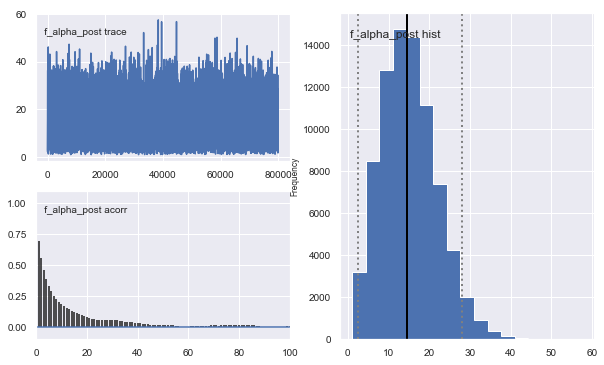

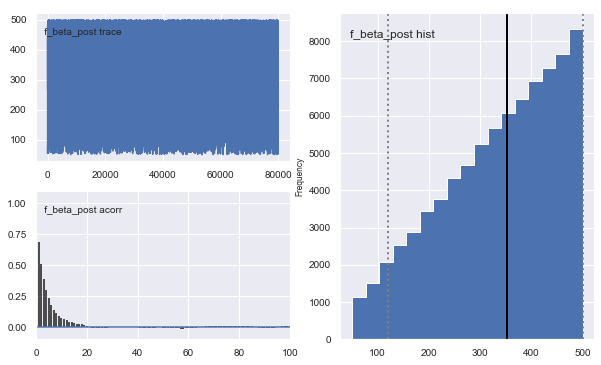

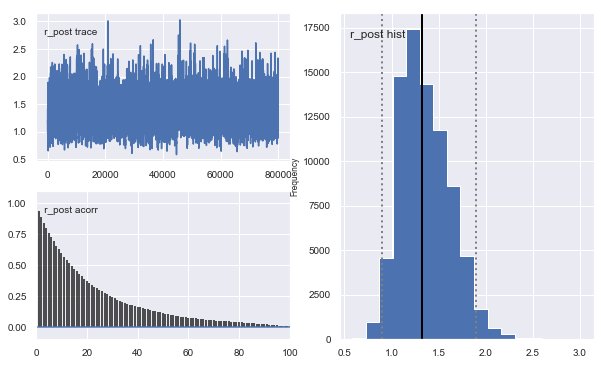

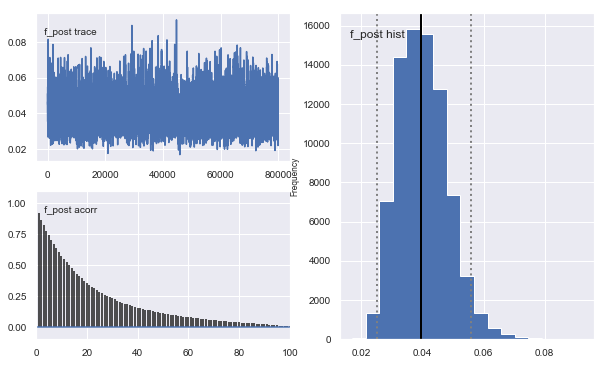

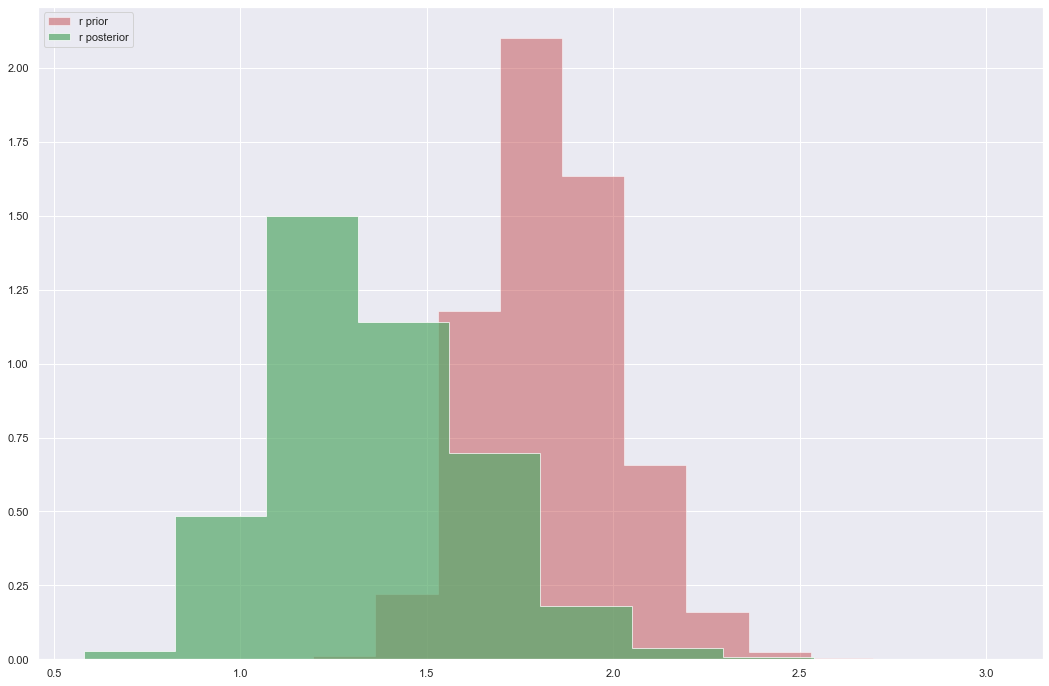

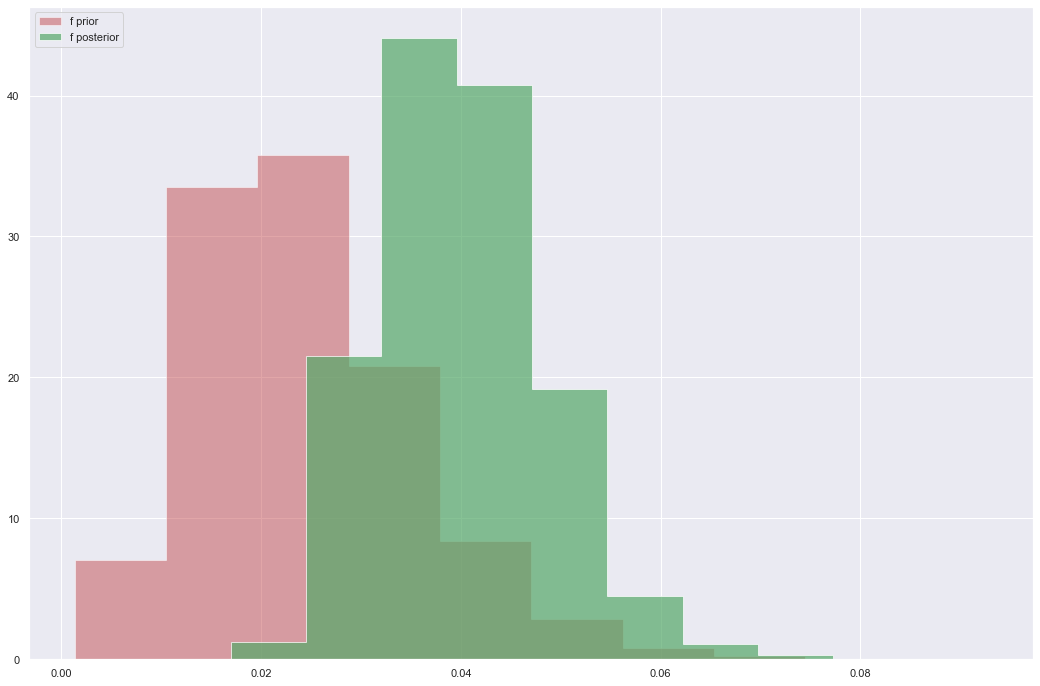

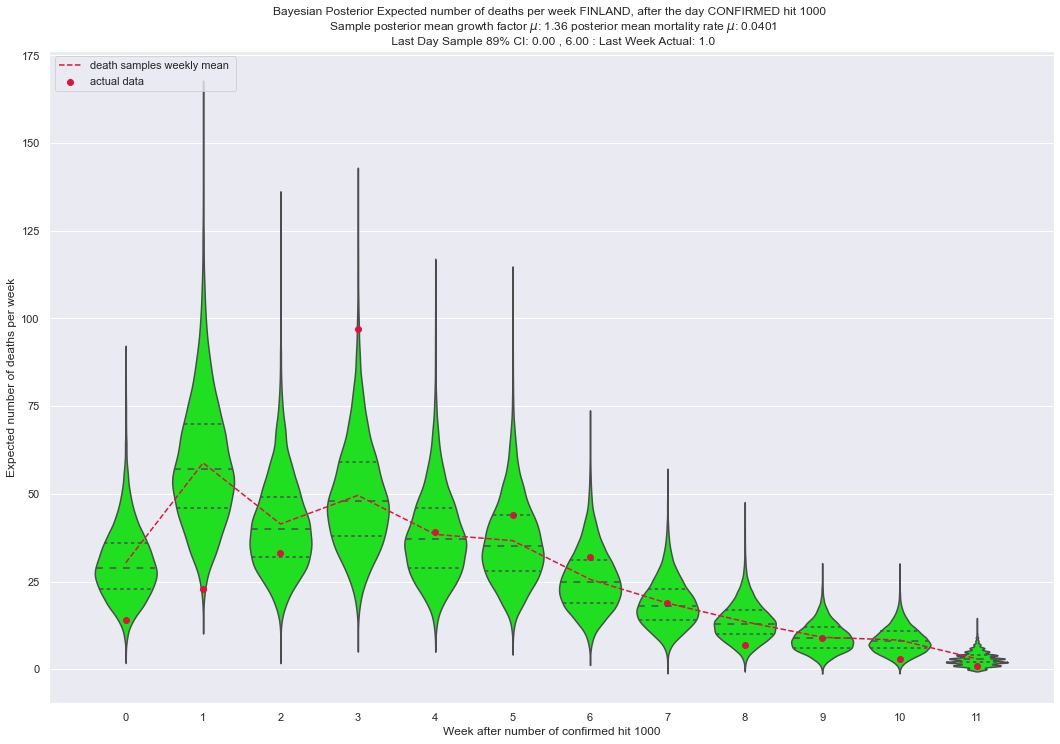

In [28]:
countries = ['Sweden','US','India','Italy',
             'Korea, South','Netherlands','Canada','Germany',
             'United Kingdom','France','Belgium','Austria','Norway','Denmark','Finland']


#countries = ['Finland','Norway','Denmark','Iceland','Australia','Russia','France','United Kingdom',
            #'Japan','Hong Kong']

#countries = ['Canada','United Kingdom','Australia','Russia']


for country_name in countries:
    
    df = process_country(country_name)

    limit = 1000
    mask = df['confirmed'] >= limit
    df = df[mask]

    #df = df[-10:]
    
    resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
    today = pd.datetime.today().weekday()

    yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]

    df = df.resample(yesterday(today)).agg({'confirmed' : np.mean,'inc': np.sum,'dead_inc':np.sum,'deceased':np.mean})
    D = df['dead_inc'].resample(yesterday(today)).sum().astype(int)
    #C = df['confirmed'].resample(yesterday(today)).mean().astype(int)
    C = df['inc'].resample(yesterday(today)).mean().astype(int)

    
    print()
    print ('+++++++++++++ {} +++++++++++++'.format(country_name))
    print (df)


    result = inference(df,C,D,country_name)
    sample_df = create_posterior_samples(result)
    #print (sample_df.head(40))
    sample_df.iloc[-1].describe()
    plot(result,df,sample_df,country_name)

In [29]:
US = pd.read_pickle('us_state_dict.pkl')

In [30]:
ny = US['New York']
ny.index = pd.DatetimeIndex(ny.index)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


 [-----------------100%-----------------] 500000 of 500000 complete in 671.7 secPlotting r_mu_post
Plotting r_sigma_post
Plotting f_alpha_post
Plotting f_beta_post
Plotting r_post
Plotting f_post

++++++++++++++ New York ++++++++++++++++
             r_post        f_post  prediction_post
count  80000.000000  80000.000000     80000.000000
mean       1.297054      0.007078        17.561437
std        0.218303      0.001140         0.099583
min        0.830089      0.004003        17.078040
25%        1.137247      0.006277        17.493843
50%        1.263153      0.007076        17.561143
75%        1.424188      0.007857        17.628918
max        2.233839      0.010789        18.026882



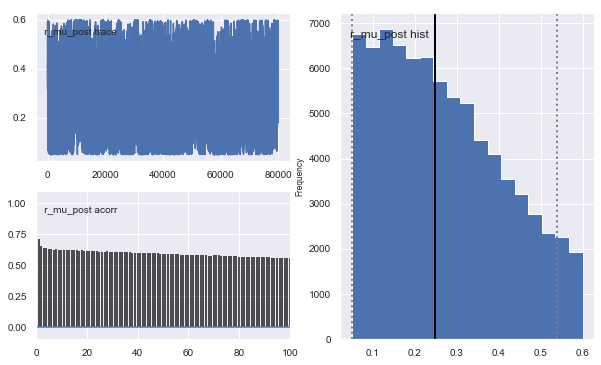

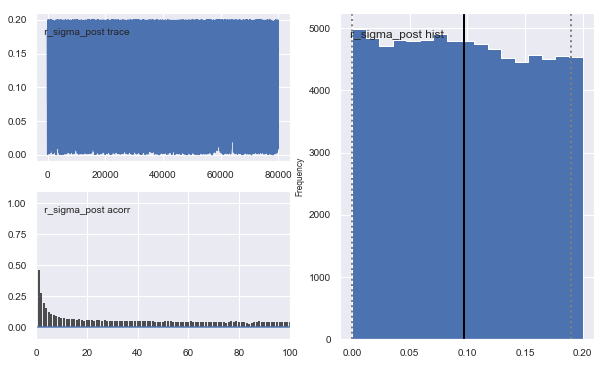

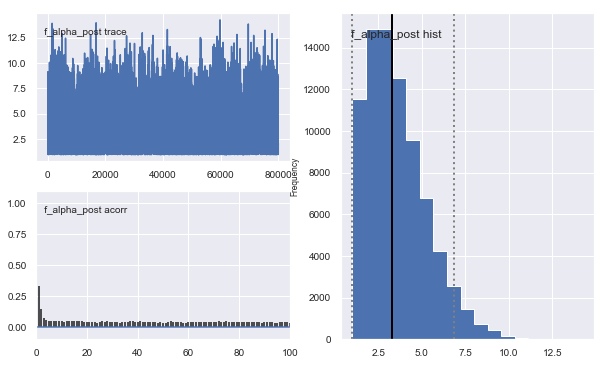

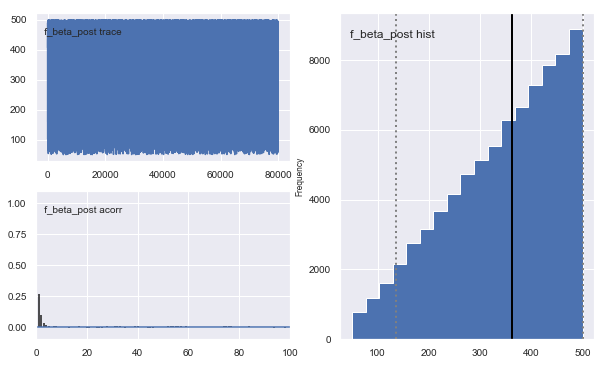

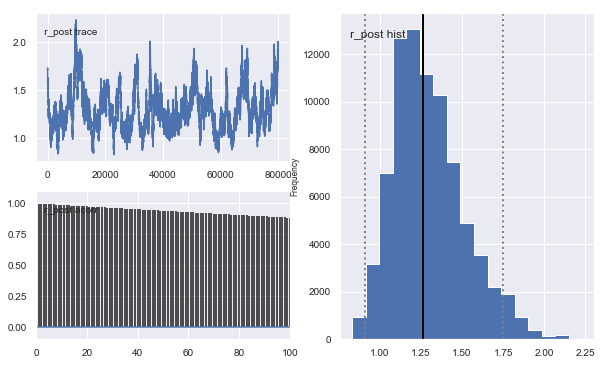

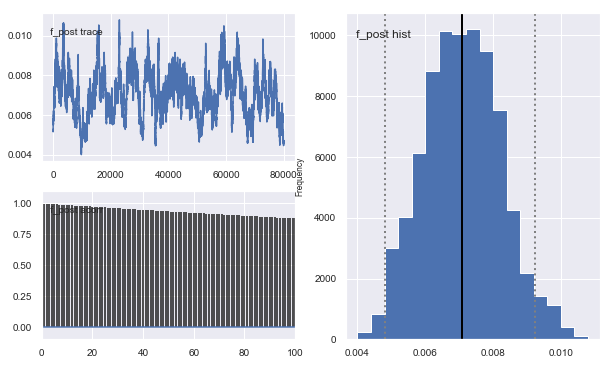

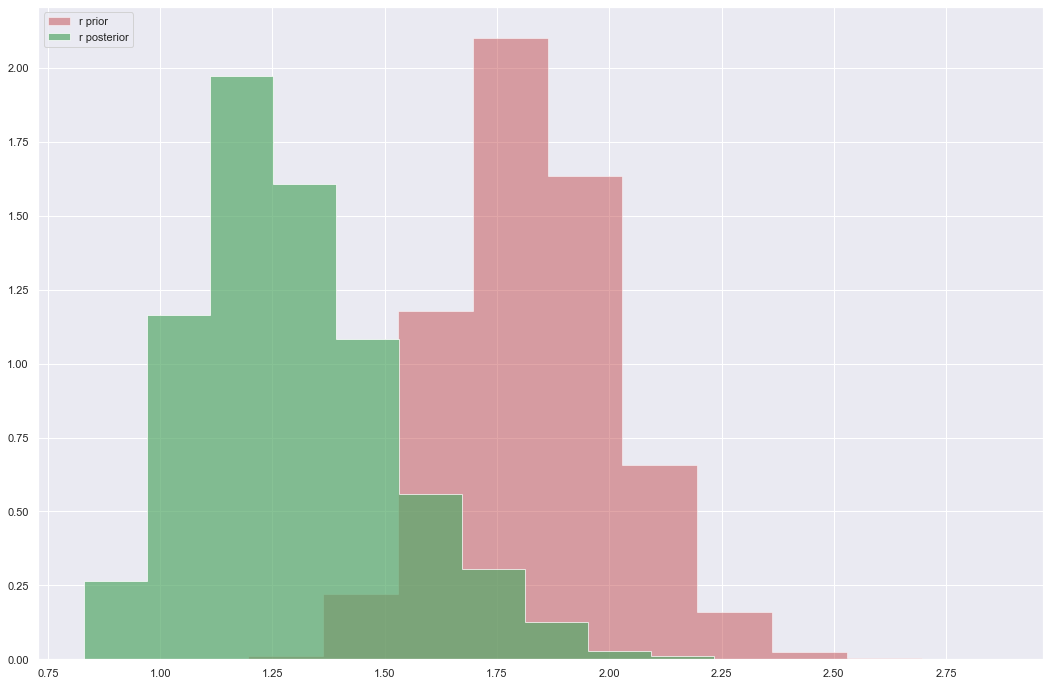

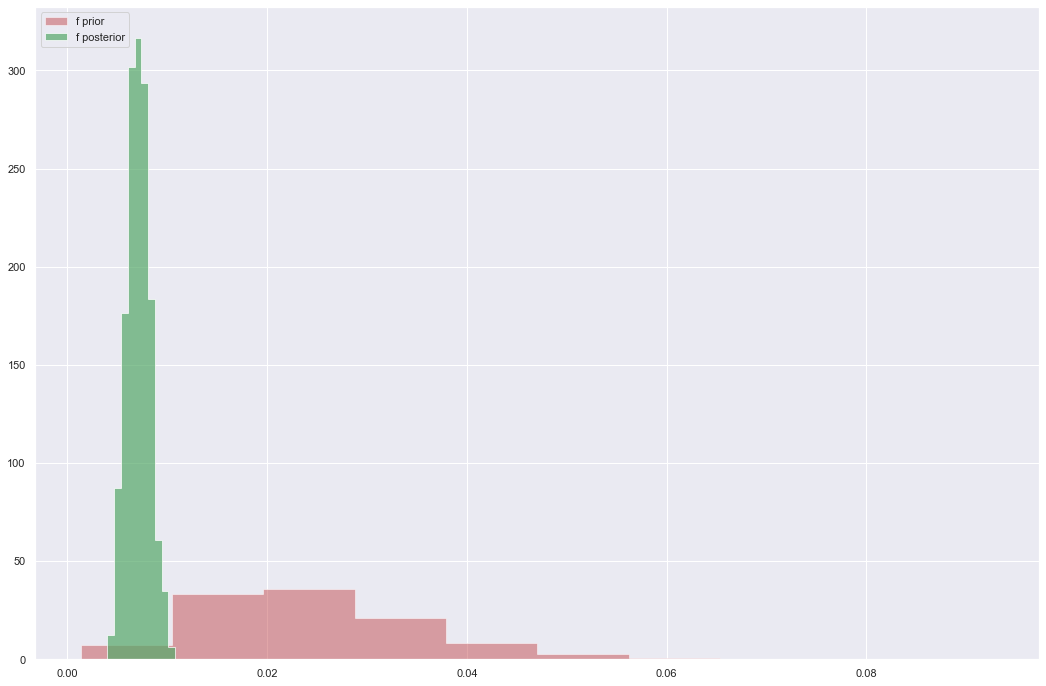

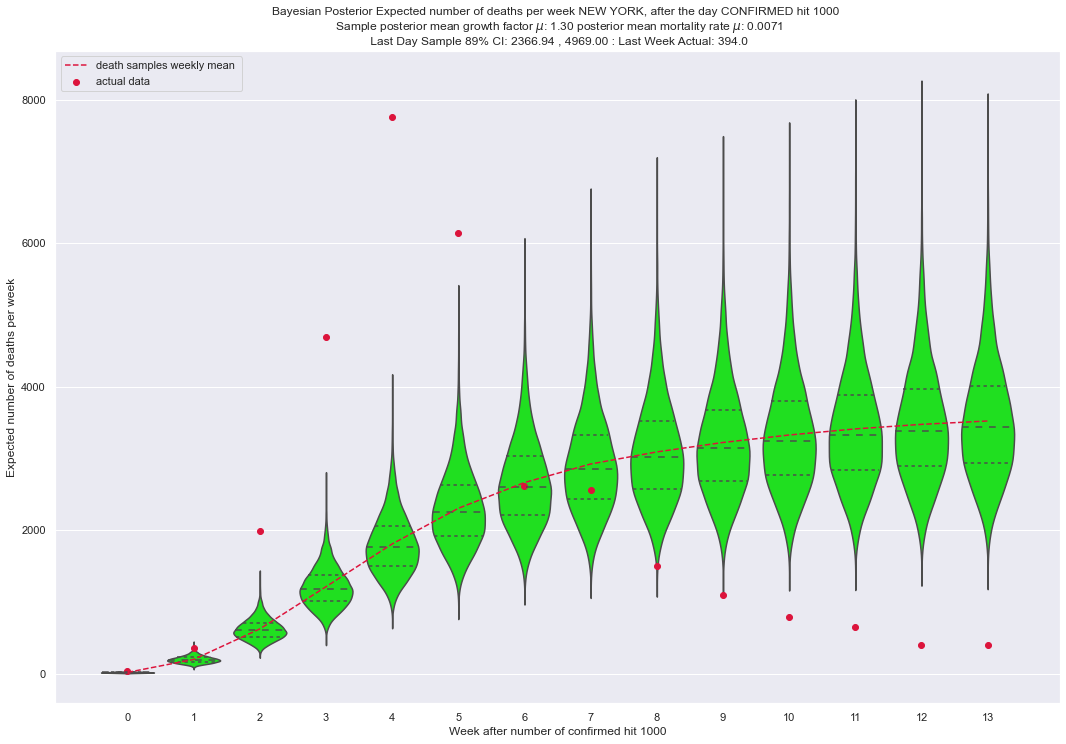

In [31]:
resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
today = pd.datetime.today().weekday()

yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]

ny = ny.resample(yesterday(today)).agg({'confirmed' : np.mean,'inc':np.sum,'dead_inc':np.sum,'deceased':np.mean})
D = ny['dead_inc'].resample(yesterday(today)).sum().astype(int)
C = ny['confirmed'].resample(yesterday(today)).mean().astype(int)    
#C = ny['inc'].resample(yesterday(today)).mean().astype(int)    

#D = ny['dead_inc']
#C = ny['confirmed']

#print (D)

result = inference(ny,C,D,'New York')
sample_df = create_posterior_samples(result)
plot(result,ny,sample_df,'New York')